<img src='https://raw.githubusercontent.com/AIdward/predict-traffic-accident/master/src/title.PNG'>

# <font size=6>Content</font><br>
<font size=3>
    
**[1. 초기 설정 및 필요한 코드 작성](#1)**

  * [1.1. 모듈 임포트](#1-1)
      * [1.1.1 기본 모듈 임포트와 초기 설정](#1-1-1)
      * [1.1.2 머신러닝을 위한 모듈 임포트](#1-1-2)
  * [1.2. 함수 생성](#1-2)
      * [1.2.1 공간데이터 삽입 함수](#1-2-1)
      * [1.2.2 격자데이터 삽입 함수](#1-2-2)
  * [1.3. 시각화 이전 작업](#1-3)
  * [1.4. 격자 데이터 분석](#1-4)
    
**[2. 어린이 보호구역 외 어린이 교통사고 위험지역 20개소 제시 (해결과제1)](#2)**

  * [2.1 데이터 전처리](#2-1)
      * [2.1.1 유동인구 데이터](#2-1-1)
      * [2.1.2 어린이인구, 총인구](#2-1-2)
      * [2.1.3 도로 데이터](#2-1-3)
      * [2.1.4 주변 시설](#2-1-4)
      * [2.1.5 교통사고 발생 현황](#2-1-5)
      * [2.1.6 나머지 데이터](#2-1-6)
  * [2.2 70x70 격자로 데이터 병합](#2-2)
      * [2.2.1 교통위험도지수 데이터 병합](#2-2-1)
      * [2.2.2 시설물 데이터 병합](#2-2-2)
  * [2.3. 머신러닝을 활용한 위험도 지수 도출](#2-3)
  * [2.4. 최적화 모델을 활용한 어린이 교통사고 위험지역 도출](#2-4)    
  * [2.5. 어린이 보호구역 외 격자데이터 산출](#2-5)
  * [2.6. MLCP를 통한 20개의 어린이 보호구역 외 교통사고 위험지역 최적화](#2-6)
    
**[3. 어린이 보호구역 중 교통안전시설물 우선 설치 지역 20개소 제시 (해결과제2)](#3)**

  * [3.1 어린이 보호구역 91개 중 위험지수가 높은 20곳 선정](#3-1)
  * [3.2 위험지수가 높은 20곳 각각에서 가장 위험한 곳 특징짓기](#3-2)
  * [3.3 시설물 우선설치지수 도출](#3-3)
      * [3.3.1 글로벌 가중치](#3-3-1)
      * [3.3.2 국소적 가중치](#3-3-2)
      * [3.3.3 시설물 부족도](#3-3-3)
      * [3.3.4 시설물 우선설치지수](#3-3-4)
  * [3.4 시설물우선설치지수를 이용한 시설물 삽입](#3-4)

# <a id=1>1. 초기 설정 및 필요한 코드 작성

# 1.1 모듈 임포트<a id=1-1></a>

## (1) 기본 모듈 임포트와 초기 설정<a id=1-1-1></a>

In [1]:
import warnings
warnings.filterwarnings(action='ignore')
from geoband.API import *
import time
from tqdm import tqdm
from shapely.geometry import Point, shape
from sklearn.preprocessing import MinMaxScaler
import geopandas as gpd
import pandas as pd
import pydeck as pdk
import numpy as np
from numpy import random
import pydeck as pdk
import shapely
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## (2) 머신러닝을 위한 모듈 임포트<a id=1-1-2></a>

In [2]:
# 머신러닝을 위한 모듈 임포트
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import sklearn.cluster
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import LeaveOneOut, cross_val_score, KFold
import lightgbm as lgb
import xgboost
import pathlib
from functools import reduce
from collections import defaultdict
from IPython.display import display
import os

import cufflinks as cf 
cf.go_offline(connected=True)
cf.set_config_file(theme='polar')
from mip import Model, xsum, maximize, BINARY  
import jenkspy

Using Python-MIP package version 1.5.3


# 1-2 함수 생성<a id=1-2></a>

## (1) 공간데이터 처리 함수<a id=1-2-1></a>
- pydeck은 shapely.geometry.도형 형태를 읽지 못하므로 geometry 에 연속된 포인트들을 갖는 리스트 값이 있어야 합니다
- 그러므로 주어진 데이터에 있는 geometry값들을 연속된 포인트들을 갖는 리스트로 바꾸어주어야 합니다
- 이외에도 좌표, 포인트, 폴리곤 등 데이터 형식을 유동적으로 바꿀 수 있도록 하였습니다
- 추가로 필요한 함수들도 언제든 가져다 쓸 수 있도록 미리 만들어 놓았습니다

In [3]:
# 포인트 리스트를 위도, 경도 두가지 컬럼을 가지도록 변환해주는 함수
def 포인트리스트_위도경도(데이터):
    lon=[]
    lat=[]
    for i, v in 데이터.iterrows():
        lon.append(v['좌표값'][0][0])
        lat.append(v['좌표값'][0][1])
    데이터['lon'] = lon
    데이터['lat'] = lat
    return 데이터

# 위도, 경도 두가지 컬럼을 포인트 리스트로 변환해주는 함수
def 위도경도_포인트리스트(데이터):
    리스트좌표 = []
    for i in range(len(데이터)):
        리스트좌표.append([데이터.loc[i, 'lon'],데이터.loc[i, 'lat']])
    데이터['리스트좌표'] = 리스트좌표

# polygon을 리스트 데이터로 변환하는 함수
def 폴리곤_좌표리스트_변환(x): 
    lon, lat = x.exterior.xy 
    return [[x, y] for x, y in zip(lon, lat)]

# multilpolygon을 리스트 데이터로 변환하는 함수
def 멀티폴리곤_좌표리스트_변환(x): 
    lon, lat = x[0].exterior.xy 
    return [[x, y] for x, y in zip(lon, lat)] 

# multilinestring을 리스트 데이터로 변환하는 함수
def 멀티선_좌표리스트_변환(L): 
    if isinstance(L, shapely.geometry.linestring.LineString): 
        lon, lat = L.xy 
        return [[x, y] for x, y in zip(lon, lat)] 
    elif isinstance(L, shapely.geometry.multilinestring.MultiLineString): 
        좌표리스트 = [] 
        for i in range(len(L)): 
            lon, lat = L[i].xy 
            for x, y in zip(lon, lat): 
                좌표리스트.append([x, y])
        return 좌표리스트

# 포인트를 좌표리스트로 변환해주는 함수
def 포인트_좌표리스트_변환(x): 
    lon, lat = x.coords.xy 
    return [[x, y] for x, y in zip(lon, lat)]

# 포인트를 공관좌표로 변환해주는 함수
def 포인트_공간좌표_변환(데이터):
    공간좌표 = []
    for i in range(len(데이터)):
        cent = [[데이터.loc[i,'lon'],데이터.loc[i,'lat']]]
        공간좌표.append(Point(cent[0]))
    데이터['공간좌표'] = 공간좌표
    
# 격자데이터 포인트좌표가 어린이 보호구역 내에 있는지 가려내는 함수
def 격자_어린이보호구역(데이터):
    격자_조밀한격자['어린이보호구역'] = 0
    for i in range(len(데이터)):               
        위치 = 격자_조밀한격자[(격자데이터['lon'] <= 데이터.loc[i,'lon']+one_meter*300)&
                            (격자데이터['lat'] <= 데이터.loc[i,'lat']+one_meter*300)&
                            (데이터.loc[i,'lon']-one_meter*300 <= 격자데이터['lon'])&
                            (데이터.loc[i,'lat']-one_meter*300 <= 격자데이터['lat'])
                ].index
        격자_조밀한격자.loc[위치,'어린이보호구역'] = 1

## (2) 격자데이터 삽입 함수<a id=1-2-2></a>
- 기준 좌표 (격자데이터)에 값을 할당하는 함수를 만들어 어떤 데이터든 할당시킬 수 있도록 하였습니다
- 할당 반경을 미리 설정하여 가져다 쓸 수 있도록 하였습니다
- 할당 시 거리에 따른 가중치를 부여할 수 있는 함수도 만들어 정확도를 높였습니다
- 삽입하려는 데이터의 수가 많으면 코드 진행속도가 오래 걸리므로 얼마나 진행되었는지를 볼 수 있는 기능도 넣었습니다

In [4]:
# 좌표계 기준 1m 미리 설정
one_meter = 0.0000113

def 기준좌표에삽입50(데이터):
    격자데이터[데이터.columns[2]] = 0
    for i in tqdm(range(len(데이터))):               
        위치 = 격자데이터[(격자데이터['lon'] <= 데이터.loc[i,'lon']+one_meter*50)&
                            (격자데이터['lat'] <= 데이터.loc[i,'lat']+one_meter*50)&
                            (데이터.loc[i,'lon']-one_meter*50 <= 격자데이터['lon'])&
                            (데이터.loc[i,'lat']-one_meter*50 <= 격자데이터['lat'])
                ].index
        격자데이터.loc[위치,데이터.columns[2]]+=데이터.loc[i, 데이터.columns[2]]
    print("반경 50m내의 격자포인트에 데이터를 성공적으로 할당하였습니다")

def 기준좌표에삽입100(데이터):
    격자데이터[데이터.columns[2]] = 0
    for i in tqdm(range(len(데이터))):               
        위치 = 격자데이터[(격자데이터['lon'] <= 데이터.loc[i,'lon']+one_meter*100)&
                            (격자데이터['lat'] <= 데이터.loc[i,'lat']+one_meter*100)&
                            (데이터.loc[i,'lon']-one_meter*100 <= 격자데이터['lon'])&
                            (데이터.loc[i,'lat']-one_meter*100 <= 격자데이터['lat'])
                ].index
        격자데이터.loc[위치,데이터.columns[2]]+=데이터.loc[i, 데이터.columns[2]]
    print("반경 100m내의 격자포인트에 데이터를 성공적으로 할당하였습니다")
        
def 기준좌표에삽입150(데이터):
    격자데이터[데이터.columns[2]] = 0
    for i in tqdm(range(len(데이터))):               
        위치 = 격자데이터[(격자데이터['lon'] <= 데이터.loc[i,'lon']+one_meter*150)&
                            (격자데이터['lat'] <= 데이터.loc[i,'lat']+one_meter*150)&
                            (데이터.loc[i,'lon']-one_meter*150 <= 격자데이터['lon'])&
                            (데이터.loc[i,'lat']-one_meter*150 <= 격자데이터['lat'])
                ].index
        격자데이터.loc[위치,데이터.columns[2]]+=데이터.loc[i, 데이터.columns[2]]
    print("반경 150m내의 격자포인트에 데이터를 성공적으로 할당하였습니다")

# 반경을 세 구역으로 나누어 데이터를 할당하는 함수도 만들었습니다
# 더 가까울수록 가중치를 두는 처리가 필요할 수 있기 때문입니다

def 기준좌표에가중치로삽입90(데이터):
    격자데이터[데이터.columns[2]] = 0
    for i in tqdm(range(len(데이터))):               
        위치 = 격자데이터[(격자데이터['lon'] <= 데이터.loc[i,'lon']+one_meter*90)&
                            (격자데이터['lat'] <= 데이터.loc[i,'lat']+one_meter*90)&
                            (데이터.loc[i,'lon']-one_meter*90 <= 격자데이터['lon'])&
                            (데이터.loc[i,'lat']-one_meter*90 <= 격자데이터['lat'])
                ].index
        격자데이터.loc[위치,데이터.columns[2]]+=데이터.loc[i, 데이터.columns[2]]
    print("반경 90m내의 격자포인트에 가중치 1을 두어 데이터를 성공적으로 할당하였습니다")
    for i in tqdm(range(len(데이터))):               
        위치 = 격자데이터[(격자데이터['lon'] <= 데이터.loc[i,'lon']+one_meter*60)&
                            (격자데이터['lat'] <= 데이터.loc[i,'lat']+one_meter*60)&
                            (데이터.loc[i,'lon']-one_meter*60 <= 격자데이터['lon'])&
                            (데이터.loc[i,'lat']-one_meter*60 <= 격자데이터['lat'])
                ].index
        격자데이터.loc[위치,데이터.columns[2]]+=데이터.loc[i, 데이터.columns[2]]
    print("반경 60m내의 격자포인트에 가중치 2을 두어 데이터를 성공적으로 할당하였습니다")
    for i in tqdm(range(len(데이터))):               
        위치 = 격자데이터[(격자데이터['lon'] <= 데이터.loc[i,'lon']+one_meter*30)&
                            (격자데이터['lat'] <= 데이터.loc[i,'lat']+one_meter*30)&
                            (데이터.loc[i,'lon']-one_meter*30 <= 격자데이터['lon'])&
                            (데이터.loc[i,'lat']-one_meter*30 <= 격자데이터['lat'])
                ].index
        격자데이터.loc[위치,데이터.columns[2]]+=데이터.loc[i, 데이터.columns[2]]
    print("반경 30m내의 격자포인트에 가중치 3을 두어 데이터를 성공적으로 할당하였습니다")   
    
def 기준좌표에가중치로삽입150(데이터):
    격자데이터[데이터.columns[2]] = 0
    for i in tqdm(range(len(데이터))):               
        위치 = 격자데이터[(격자데이터['lon'] <= 데이터.loc[i,'lon']+one_meter*150)&
                            (격자데이터['lat'] <= 데이터.loc[i,'lat']+one_meter*150)&
                            (데이터.loc[i,'lon']-one_meter*150 <= 격자데이터['lon'])&
                            (데이터.loc[i,'lat']-one_meter*150 <= 격자데이터['lat'])
                ].index
        격자데이터.loc[위치,데이터.columns[2]]+=데이터.loc[i, 데이터.columns[2]]
    print("반경 150m내의 격자포인트에 가중치 1을 두어 데이터를 성공적으로 할당하였습니다")
    for i in tqdm(range(len(데이터))):               
        위치 = 격자데이터[(격자데이터['lon'] <= 데이터.loc[i,'lon']+one_meter*100)&
                            (격자데이터['lat'] <= 데이터.loc[i,'lat']+one_meter*100)&
                            (데이터.loc[i,'lon']-one_meter*100 <= 격자데이터['lon'])&
                            (데이터.loc[i,'lat']-one_meter*100 <= 격자데이터['lat'])
                ].index
        격자데이터.loc[위치,데이터.columns[2]]+=데이터.loc[i, 데이터.columns[2]]
    print("반경 100m내의 격자포인트에 가중치 2을 두어 데이터를 성공적으로 할당하였습니다")
    for i in tqdm(range(len(데이터))):               
        위치 = 격자데이터[(격자데이터['lon'] <= 데이터.loc[i,'lon']+one_meter*50)&
                            (격자데이터['lat'] <= 데이터.loc[i,'lat']+one_meter*50)&
                            (데이터.loc[i,'lon']-one_meter*50 <= 격자데이터['lon'])&
                            (데이터.loc[i,'lat']-one_meter*50 <= 격자데이터['lat'])
                ].index
        격자데이터.loc[위치,데이터.columns[2]]+=데이터.loc[i, 데이터.columns[2]]
    print("반경 50m내의 격자포인트에 가중치 3을 두어 데이터를 성공적으로 할당하였습니다")

def 기준좌표에가중치로삽입240(데이터):
    격자데이터[데이터.columns[2]] = 0
    for i in tqdm(range(len(데이터))):               
        위치 = 격자데이터[(격자데이터['lon'] <= 데이터.loc[i,'lon']+one_meter*240)&
                            (격자데이터['lat'] <= 데이터.loc[i,'lat']+one_meter*240)&
                            (데이터.loc[i,'lon']-one_meter*240 <= 격자데이터['lon'])&
                            (데이터.loc[i,'lat']-one_meter*240 <= 격자데이터['lat'])
                ].index
        격자데이터.loc[위치,데이터.columns[2]]+=데이터.loc[i, 데이터.columns[2]]
    print("반경 240m내의 격자포인트에 가중치 1을 두어 데이터를 성공적으로 할당하였습니다")
    for i in tqdm(range(len(데이터))):               
        위치 = 격자데이터[(격자데이터['lon'] <= 데이터.loc[i,'lon']+one_meter*160)&
                            (격자데이터['lat'] <= 데이터.loc[i,'lat']+one_meter*160)&
                            (데이터.loc[i,'lon']-one_meter*160 <= 격자데이터['lon'])&
                            (데이터.loc[i,'lat']-one_meter*160 <= 격자데이터['lat'])
                ].index
        격자데이터.loc[위치,데이터.columns[2]]+=데이터.loc[i, 데이터.columns[2]]
    print("반경 160m내의 격자포인트에 가중치 2을 두어 데이터를 성공적으로 할당하였습니다")
    for i in tqdm(range(len(데이터))):               
        위치 = 격자데이터[(격자데이터['lon'] <= 데이터.loc[i,'lon']+one_meter*80)&
                            (격자데이터['lat'] <= 데이터.loc[i,'lat']+one_meter*80)&
                            (데이터.loc[i,'lon']-one_meter*80 <= 격자데이터['lon'])&
                            (데이터.loc[i,'lat']-one_meter*80 <= 격자데이터['lat'])
                ].index
        격자데이터.loc[위치,데이터.columns[2]]+=데이터.loc[i, 데이터.columns[2]]
    print("반경 80m내의 격자포인트에 가중치 3을 두어 데이터를 성공적으로 할당하였습니다")
        
def 기준좌표에가중치로삽입300(데이터):
    격자데이터[데이터.columns[2]] = 0
    for i in tqdm(range(len(데이터))):               
        위치 = 격자데이터[(격자데이터['lon'] <= 데이터.loc[i,'lon']+one_meter*300)&
                            (격자데이터['lat'] <= 데이터.loc[i,'lat']+one_meter*300)&
                            (데이터.loc[i,'lon']-one_meter*300 <= 격자데이터['lon'])&
                            (데이터.loc[i,'lat']-one_meter*300 <= 격자데이터['lat'])
                ].index
        격자데이터.loc[위치,데이터.columns[2]]+=데이터.loc[i, 데이터.columns[2]]
    print("반경 300m내의 격자포인트에 가중치 1을 두어 데이터를 성공적으로 할당하였습니다")
    for i in tqdm(range(len(데이터))):               
        위치 = 격자데이터[(격자데이터['lon'] <= 데이터.loc[i,'lon']+one_meter*200)&
                            (격자데이터['lat'] <= 데이터.loc[i,'lat']+one_meter*200)&
                            (데이터.loc[i,'lon']-one_meter*200 <= 격자데이터['lon'])&
                            (데이터.loc[i,'lat']-one_meter*200 <= 격자데이터['lat'])
                ].index
        격자데이터.loc[위치,데이터.columns[2]]+=데이터.loc[i, 데이터.columns[2]]
    print("반경 200m내의 격자포인트에 가중치 2을 두어 데이터를 성공적으로 할당하였습니다")
    for i in tqdm(range(len(데이터))):               
        위치 = 격자데이터[(격자데이터['lon'] <= 데이터.loc[i,'lon']+one_meter*100)&
                            (격자데이터['lat'] <= 데이터.loc[i,'lat']+one_meter*100)&
                            (데이터.loc[i,'lon']-one_meter*100 <= 격자데이터['lon'])&
                            (데이터.loc[i,'lat']-one_meter*100 <= 격자데이터['lat'])
                ].index
        격자데이터.loc[위치,데이터.columns[2]]+=데이터.loc[i, 데이터.columns[2]]
    print("반경 100m내의 격자포인트에 가중치 3을 두어 데이터를 성공적으로 할당하였습니다")
    
def 기준좌표에가중치로삽입450(데이터):
    격자데이터[데이터.columns[2]] = 0
    for i in tqdm(range(len(데이터))):               
        위치 = 격자데이터[(격자데이터['lon'] <= 데이터.loc[i,'lon']+one_meter*450)&
                            (격자데이터['lat'] <= 데이터.loc[i,'lat']+one_meter*450)&
                            (데이터.loc[i,'lon']-one_meter*450 <= 격자데이터['lon'])&
                            (데이터.loc[i,'lat']-one_meter*450 <= 격자데이터['lat'])
                ].index
        격자데이터.loc[위치,데이터.columns[2]]+=데이터.loc[i, 데이터.columns[2]]
    print("반경 450m내의 격자포인트에 가중치 1을 두어 데이터를 성공적으로 할당하였습니다")
    for i in tqdm(range(len(데이터))):               
        위치 = 격자데이터[(격자데이터['lon'] <= 데이터.loc[i,'lon']+one_meter*300)&
                            (격자데이터['lat'] <= 데이터.loc[i,'lat']+one_meter*300)&
                            (데이터.loc[i,'lon']-one_meter*300 <= 격자데이터['lon'])&
                            (데이터.loc[i,'lat']-one_meter*300 <= 격자데이터['lat'])
                ].index
        격자데이터.loc[위치,데이터.columns[2]]+=데이터.loc[i, 데이터.columns[2]]
    print("반경 300m내의 격자포인트에 가중치 2을 두어 데이터를 성공적으로 할당하였습니다")
    for i in tqdm(range(len(데이터))):               
        위치 = 격자데이터[(격자데이터['lon'] <= 데이터.loc[i,'lon']+one_meter*150)&
                            (격자데이터['lat'] <= 데이터.loc[i,'lat']+one_meter*150)&
                            (데이터.loc[i,'lon']-one_meter*150 <= 격자데이터['lon'])&
                            (데이터.loc[i,'lat']-one_meter*150 <= 격자데이터['lat'])
                ].index
        격자데이터.loc[위치,데이터.columns[2]]+=데이터.loc[i, 데이터.columns[2]]
    print("반경 150m내의 격자포인트에 가중치 3을 두어 데이터를 성공적으로 할당하였습니다")
    
# 안전시설물을 삽입할 때의 함수를 따로 작성하였습니다
# 반경을 조금 더 넓히고, 가까울수록 가중치를 비교적 많이 부여하기 위함입니다
def 기준좌표에가중치로교통안전시설삽입(데이터):
    격자데이터[데이터.columns[2]] = 0
    for i in tqdm(range(len(데이터))):               
        위치 = 격자데이터[(격자데이터['lon'] <= 데이터.loc[i,'lon']+one_meter*500)&
                            (격자데이터['lat'] <= 데이터.loc[i,'lat']+one_meter*500)&
                            (데이터.loc[i,'lon']-one_meter*500 <= 격자데이터['lon'])&
                            (데이터.loc[i,'lat']-one_meter*500 <= 격자데이터['lat'])
                ].index
        격자데이터.loc[위치,데이터.columns[2]]+=데이터.loc[i, 데이터.columns[2]]
    print("반경 500m내의 격자포인트에 가중치 1을 두어 데이터를 성공적으로 할당하였습니다")
    for i in tqdm(range(len(데이터))):               
        위치 = 격자데이터[(격자데이터['lon'] <= 데이터.loc[i,'lon']+one_meter*300)&
                            (격자데이터['lat'] <= 데이터.loc[i,'lat']+one_meter*300)&
                            (데이터.loc[i,'lon']-one_meter*300 <= 격자데이터['lon'])&
                            (데이터.loc[i,'lat']-one_meter*300 <= 격자데이터['lat'])
                ].index
        격자데이터.loc[위치,데이터.columns[2]]+=데이터.loc[i, 데이터.columns[2]]
    print("반경 300m내의 격자포인트에 가중치 3을 두어 데이터를 성공적으로 할당하였습니다")
    for i in tqdm(range(len(데이터))):               
        위치 = 격자데이터[(격자데이터['lon'] <= 데이터.loc[i,'lon']+one_meter*100)&
                            (격자데이터['lat'] <= 데이터.loc[i,'lat']+one_meter*100)&
                            (데이터.loc[i,'lon']-one_meter*100 <= 격자데이터['lon'])&
                            (데이터.loc[i,'lat']-one_meter*100 <= 격자데이터['lat'])
                ].index
        격자데이터.loc[위치,데이터.columns[2]]+=데이터.loc[i, 데이터.columns[2]]
    print("반경 100m내의 격자포인트에 가중치 5을 두어 데이터를 성공적으로 할당하였습니다")

# 1-3 시각화 이전 작업<a id=1-3></a>

#### 데이터 분석 목록
31. 오산시_법정경계(시군구).geojson  
32. 오산시_행정경계(읍면동).geojson  
33. 오산시_법정경계(읍면동).geojson

- 시각화를 할 때마다 지도상에 오산시 경계를 표시하여 효과적으로 시각화를 하고자 합니다  

In [5]:
# 경계 데이터 가져오기
GetCompasData('SBJ_2012_001', '31', '31.오산시_법정경계(시군구).geojson')
GetCompasData('SBJ_2012_001', '32', '32.오산시_행정경계(읍면동).geojson')
GetCompasData('SBJ_2012_001', '33', '33.오산시_법정경계(읍면동).geojson')
# 경계 데이터 입력하기
법정경계_시군구 = gpd.read_file("31.오산시_법정경계(시군구).geojson")
행정경계_읍면동 = gpd.read_file("32.오산시_행정경계(읍면동).geojson")
법정경계_읍면동 = gpd.read_file("33.오산시_법정경계(읍면동).geojson")

In [6]:
# 법정경계 데이터를 pydeck에서 처리할 수 있게 변환하였습니다
법정경계_읍면동['좌표값'] = 법정경계_읍면동['geometry'].apply(멀티폴리곤_좌표리스트_변환)
del 법정경계_읍면동['geometry']
법정경계_읍면동 = pd.DataFrame(법정경계_읍면동)

In [7]:
# 법정경계 pydeck 레이어를 나중에 가져다 쓸 수 있도록 미리 만들어 놓았습니다
읍면동맵 = pdk.Layer('PolygonLayer', 
                   법정경계_읍면동, 
                   get_polygon='좌표값', 
                   get_fill_color='[50,100,150,30]',
                   get_line_color='[250, 250, 250]',
                   pickable=True, 
                   lineWidthScale=30,
                   auto_highlight=True)

# pydeck을 실행할 때의 View 초기값을 미리 입력하여 나중에 가져다 쓸 수 있도록 하였습니다
center = (37.163,127.054)
zoom = 11.5
view_state = pdk.ViewState(
    longitude=center[1],
    latitude=center[0],
    zoom=zoom)

mmap = pdk.Deck(layers=[읍면동맵],
            mapbox_key = 'pk.eyJ1IjoiZWR3YXJkcm9uaWMiLCJhIjoiY2trOW9qa2UyMHpyMjJvbngxMXU2Y3gzbSJ9.3ulI8nY1yimd1b4wk6tfKw',
            initial_view_state=view_state)
mmap.to_html("읍면동맵.html", notebook_display=False)

<img src='https://raw.githubusercontent.com/AIdward/predict-traffic-accident/master/src/읍면동맵.PNG'>

# 1-4 격자 데이터 분석<a id=1-4></a>

#### 격자 데이터 분석 목록

2. 오산시_어린이교통사고_격자.geojson
3. 오산시_차량등록현황_격자.geojson
4. 오산시_연령별_거주인구격자(총인구).geojson
5. 오산시_연령별_거주인구격자(유소년).geojson
6. 오산시_연령별_거주인구격자(생산가능인구).geojson
7. 오산시_연령별_거주인구격자(고령).geojson


- 현재 주어진 격자 데이터는 100x100입니다  
- 과제에 주어진 위험지역 범위설정은 중심점으로부터 반경 50m를 기준으로 합니다   
- 격자 데이터를 세분화 할 필요가 있습니다  
- 그러므로 주어진 격자의 꼭짓점까지 추가좌표로 두어 더 조밀한 데이터들을 모을 필요가 있습니다
- 데이터 형태가 다양하기 때문에 표준 데이터 형태를 포인트로 하여 이후 모든 데이터를 표준화시켰습니다

In [8]:
# 격자 데이터를 넣으면 격자의 꼭짓점 좌표를 추가하여 반환하는 함수를 생성하였습니다
def 격자줄이기(데이터):
    꼭짓점x좌표= []
    꼭짓점y좌표 = []
    꼭짓점값 = []
    중앙x좌표 = []
    중앙y좌표 = []
    중앙값 = []
    for i, v in 데이터.iterrows():
        꼭짓점x좌표.extend([v['geometry'][0].exterior.coords[0][0],v['geometry'][0].exterior.coords[1][0],
                            v['geometry'][0].exterior.coords[2][0],v['geometry'][0].exterior.coords[3][0]])
        꼭짓점y좌표.extend([v['geometry'][0].exterior.coords[0][1],v['geometry'][0].exterior.coords[1][1],
                            v['geometry'][0].exterior.coords[2][1],v['geometry'][0].exterior.coords[3][1]])
        꼭짓점값.extend([v[데이터.columns[0]]/4,v[데이터.columns[0]]/4,v[데이터.columns[0]]/4,v[데이터.columns[0]]/4])
        중앙x좌표.append(v['geometry'].bounds[0]/2+v['geometry'].bounds[2]/2)
        중앙y좌표.append(v['geometry'].bounds[1]/2+v['geometry'].bounds[3]/2)
        중앙값.append(v[데이터.columns[0]])
    del 데이터['geometry']
    꼭짓점 = pd.DataFrame({데이터.columns[0]:꼭짓점값, 'lon':꼭짓점x좌표, 'lat':꼭짓점y좌표})
    중앙 = pd.DataFrame({데이터.columns[0]:중앙값, 'lon':중앙x좌표, 'lat':중앙y좌표})
    데이터 = pd.concat([꼭짓점,중앙], ignore_index=True, axis=0)
    return 데이터

In [9]:
# 격자 데이터 가져오기
GetCompasData('SBJ_2012_001', '2', '2.오산시_어린이교통사고_격자.geojson')
GetCompasData('SBJ_2012_001', '3', '3.오산시_차량등록현황_격자.geojson')
GetCompasData('SBJ_2012_001', '4', '4.오산시_연령별_거주인구격자(총인구).geojson')
GetCompasData('SBJ_2012_001', '5', '5.오산시_연령별_거주인구격자(유소년).geojson')
GetCompasData('SBJ_2012_001', '6', '6.오산시_연령별_거주인구격자(생산가능인구).geojson')
GetCompasData('SBJ_2012_001', '7', '7.오산시_연령별_거주인구격자(고령).geojson')
# 격자 데이터 입력 (편의를 위해 데이터명을 한글로 명확히 지정)
어린이교통사고_격자 = gpd.read_file('2.오산시_어린이교통사고_격자.geojson')
차량등록현황_격자 = gpd.read_file("3.오산시_차량등록현황_격자.geojson")
총인구_격자 = gpd.read_file("4.오산시_연령별_거주인구격자(총인구).geojson")
유소년인구_격자 = gpd.read_file("5.오산시_연령별_거주인구격자(유소년).geojson")
생산가능인구_격자 = gpd.read_file("6.오산시_연령별_거주인구격자(생산가능인구).geojson")
고령인구_격자 = gpd.read_file("7.오산시_연령별_거주인구격자(고령).geojson")

In [10]:
# 격자 데이터를 한 눈에 알아보기 쉽게 column명을 재설정하였습니다
어린이교통사고_격자 = 어린이교통사고_격자.rename(columns = {"accident_cnt":"어린이교통사고횟수"})
차량등록현황_격자 = 차량등록현황_격자.rename(columns = {"car_cnt":"차량등록수"})
총인구_격자 = 총인구_격자.rename(columns = {"val":"총인구"})
유소년인구_격자 = 유소년인구_격자.rename(columns = {"val":"유소년인구"})
생산가능인구_격자 = 생산가능인구_격자.rename(columns = {"val":"생산가능인구"})
고령인구_격자 = 고령인구_격자.rename(columns = {"val":"고령인구"})

In [11]:
# gid 데이터는 추후 다루지 않을 예정이니 삭제하였습니다 
del 어린이교통사고_격자['gid']
del 차량등록현황_격자['gid']
del 총인구_격자['gid']
del 유소년인구_격자['gid']
del 생산가능인구_격자['gid']
del 고령인구_격자['gid']

# 다룰 수 없는 NaN값을 0값으로 바꾸었습니다
총인구_격자 = 총인구_격자.fillna(0.0)
유소년인구_격자 = 유소년인구_격자.fillna(0.0)
생산가능인구_격자 = 생산가능인구_격자.fillna(0.0)
고령인구_격자 = 고령인구_격자.fillna(0.0)

In [12]:
# 격자의 꼭짓점 좌표를 추가하여 반환하였습니다. 이제 모든 주어진 격자 데이터들은 조밀한 값을 가집니다 (70x70)
어린이교통사고_격자 = 격자줄이기(어린이교통사고_격자)
어린이교통사고_격자 = 어린이교통사고_격자.groupby(['lon','lat'], as_index=True)['어린이교통사고횟수'].sum().reset_index()
차량등록현황_격자 = 격자줄이기(차량등록현황_격자)
차량등록현황_격자 = 차량등록현황_격자.groupby(['lon','lat'], as_index=True)['차량등록수'].sum().reset_index()
총인구_격자 = 격자줄이기(총인구_격자)
총인구_격자 = 총인구_격자.groupby(['lon','lat'], as_index=True)['총인구'].sum().reset_index()
유소년인구_격자 = 격자줄이기(유소년인구_격자)
유소년인구_격자 = 유소년인구_격자.groupby(['lon','lat'], as_index=True)['유소년인구'].sum().reset_index()
생산가능인구_격자 = 격자줄이기(생산가능인구_격자)
생산가능인구_격자 = 생산가능인구_격자.groupby(['lon','lat'], as_index=True)['생산가능인구'].sum().reset_index()
고령인구_격자 = 격자줄이기(고령인구_격자)
고령인구_격자 = 고령인구_격자.groupby(['lon','lat'], as_index=True)['고령인구'].sum().reset_index()

In [13]:
# 격자 데이터 전 후 데이터 row개수를 비교하였습니다
# 격자 데이터 조밀화를 하기 전에는 4510개의 100x100 격자 데이터로만 존재하였습니다
GetCompasData('SBJ_2012_001', '2', '2.오산시_어린이교통사고_격자.geojson')
어린이교통사고_격자_원래격자 = gpd.read_file('2.오산시_어린이교통사고_격자.geojson')
어린이교통사고_격자_원래격자 = 어린이교통사고_격자_원래격자.rename(columns = {"accident_cnt":"어린이교통사고횟수"})
어린이교통사고_격자_원래격자

,gid,어린이교통사고횟수,geometry
0,다사551085,0,"MULTIPOLYGON (((126.99422 37.17418, 126.99421 ..."
1,다사551086,0,"MULTIPOLYGON (((126.99421 37.17508, 126.99420 ..."
2,다사551087,0,"MULTIPOLYGON (((126.99420 37.17599, 126.99420 ..."
3,다사551088,0,"MULTIPOLYGON (((126.99420 37.17689, 126.99419 ..."
4,다사552085,0,"MULTIPOLYGON (((126.99534 37.17419, 126.99534 ..."
...,...,...,...
4505,다사646052,0,"MULTIPOLYGON (((127.10138 37.14484, 127.10138 ..."
4506,다사646053,0,"MULTIPOLYGON (((127.10138 37.14575, 127.10137 ..."
4507,다사647050,0,"MULTIPOLYGON (((127.10252 37.14305, 127.10251 ..."
4508,다사647051,0,"MULTIPOLYGON (((127.10251 37.14395, 127.10251 ..."


In [14]:
# 격자 데이터 조밀화 진행 이후에는 9244개의 70x70 격자 데이터로 바뀌었습니다
# 이제 이 격자 데이터에 모든 변수들을 집어넣어 머신러닝 모델에 넣을 것이기 때문에 
# 이 과정은 매우 중요하다고 할 수 있습니다
격자_조밀한격자 = 어린이교통사고_격자.copy()
del 격자_조밀한격자['어린이교통사고횟수']
격자_조밀한격자

,lon,lat
0,126.994192,37.177788
1,126.994198,37.176887
2,126.994204,37.175985
3,126.994210,37.175084
4,126.994216,37.174182
...,...,...
9239,127.103080,37.143498
9240,127.103631,37.145754
9241,127.103636,37.144852
9242,127.103640,37.143951


# <a id=2>2. 어린이 보호구역 외 어린이 교통사고 위험지역 20개소 제시 (해결과제1)

**현 정부는 지역별, 유형별 특성에 맞는 어린이 보호구역 정비 표준모델을 마련하였습니다**  
**표준모델에 따르면 어린이 보호구역 지정여부를 조사할 때는 밑의 5가지 데이터를 이용한다고 합니다**  
**그러므로 COMPAS에서 준 데이터를 잘 활용하면 현재 어린이 보호구역 외에 추가로 어린이 교통사고 위험지역을 도출해낼 수 있습니다**

-	어린이 보행 : 유동인구(등하교시간) * 어린이인구/총인구
-	자동차 통행량 : 전체 추정 교통량
-	도로의 신호기
-	시설(초등학교, 학원, 공원, 생활체육시설, 장애인시설) 주변
-	연간 교통사고 발생현황

# 2-1. 데이터 전처리 단계<a id=2-1></a>

## (1) 유동인구 데이터 전처리<a id=2-1-1></a>

#### 데이터 분석 목록

8. 오산시_유동인구(2019).csv

- 유동인구는 50x50 조밀도로 데이터가 주어졌습니다
- 유동인구는 2019년 1월~12월까지의 데이터가 있지만 각 월마다 측정한 좌표값의 개수가 다르므로 가장 많이 측정된 5월을 기준으로 하였습니다
- 5월 유동인구는 총 11411곳이 측정되었습니다
- 초등학생 아이들의 등하교 시간을 기준으로 측정해야 정확합니다
- 등교 시간은 8-9시 안에 대부분 완료됩니다
- 하교 시간은 4교시, 5교시, 6교시를 할 때가 매번 다르므로 1-2시와 2-3시를 기준으로 합니다

In [15]:
# COMPAS에서 제공하는 유동인구 데이터를 불러왔습니다
GetCompasData('SBJ_2012_001', '8', '8.오산시_유동인구(2019).csv')
유동인구 = pd.read_csv("8.오산시_유동인구(2019).csv")
유동인구

,STD_YM,lon,lat,TMST_00,TMST_01,TMST_02,TMST_03,TMST_04,TMST_05,TMST_06,TMST_07,TMST_08,TMST_09,TMST_10,TMST_11,TMST_12,TMST_13,TMST_14,TMST_15,TMST_16,TMST_17,TMST_18,TMST_19,TMST_20,TMST_21,TMST_22,TMST_23
0,201901,126.995145,37.176703,0.08,0.05,0.04,0.04,0.08,0.27,0.80,0.94,0.68,0.70,0.73,0.69,0.64,0.72,0.69,0.76,0.95,0.91,0.70,0.43,0.34,0.22,0.14,0.10
1,201901,126.995142,37.177153,0.06,0.04,0.03,0.03,0.06,0.19,0.56,0.72,0.53,0.54,0.57,0.55,0.52,0.55,0.54,0.58,0.69,0.66,0.51,0.33,0.26,0.17,0.11,0.08
2,201901,126.995714,37.175804,0.00,0.00,0.00,0.00,0.00,0.01,0.03,0.05,0.04,0.04,0.04,0.03,0.03,0.04,0.04,0.04,0.05,0.05,0.03,0.02,0.02,0.01,0.01,0.00
3,201901,126.995711,37.176254,0.05,0.03,0.02,0.03,0.05,0.19,0.56,0.65,0.47,0.48,0.51,0.48,0.45,0.50,0.48,0.53,0.65,0.63,0.48,0.29,0.23,0.15,0.10,0.07
4,201901,126.995708,37.176705,0.02,0.01,0.01,0.01,0.02,0.07,0.18,0.24,0.19,0.20,0.20,0.20,0.19,0.20,0.19,0.20,0.23,0.22,0.17,0.11,0.09,0.06,0.04,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125158,201912,127.097213,37.154107,0.09,0.07,0.05,0.04,0.04,0.04,0.05,0.07,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.12,0.12,0.12,0.14,0.14,0.14,0.14,0.12,0.11
125159,201912,127.097819,37.145997,0.23,0.18,0.12,0.09,0.09,0.11,0.14,0.19,0.25,0.25,0.26,0.26,0.25,0.26,0.28,0.28,0.30,0.34,0.34,0.35,0.35,0.34,0.32,0.28
125160,201912,127.097793,37.150955,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.04,0.04,0.04,0.04,0.02,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04
125161,201912,127.098354,37.151407,0.02,0.02,0.02,0.00,0.00,0.00,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.04,0.04,0.04,0.04,0.02,0.02


In [16]:
# 유동인구 데이터를 가장 많은 곳이 측정된 5월을 기준으로 처리하였습니다
유동인구 = 유동인구.drop(유동인구.loc[유동인구['STD_YM']!=201905].index, inplace=False).reset_index()
# 오산시 어린이보호구역 보행안전 확보방안 연구원에서 발표한 어린이 보호구역 내 사교율을 분석한 결과 
# 8시부터 9시까지의 사교율이 12.5%인 반면 하교시간 사교율은 50% 이상이므로
# 실제 데이터와 맞도록 적당히 가중치를 부여하여 데이터를 설정해주었습니다
유동인구['TMST_08'] = 유동인구['TMST_08'] * 1
유동인구['TMST_13'] = 유동인구['TMST_13'] * 2
유동인구['TMST_14'] = 유동인구['TMST_14'] * 2
유동인구['총유동인구'] = 유동인구['TMST_08'] + 유동인구['TMST_13'] + 유동인구['TMST_14']
유동인구 = 유동인구.loc[:,['lon', 'lat', '총유동인구']]
유동인구['총유동인구'] = 유동인구['총유동인구']
유동인구

,lon,lat,총유동인구
0,126.995154,37.175351,0.60
1,126.995151,37.175801,0.64
2,126.995148,37.176252,0.25
3,126.995145,37.176703,3.23
4,126.995142,37.177153,2.57
...,...,...,...
11406,127.096715,37.141937,0.18
11407,127.096638,37.156359,0.10
11408,127.097278,37.141939,0.10
11409,127.097767,37.155912,0.08


In [17]:
# 전처리한 유동인구 데이터를 pydeck을 이용하여 시각화 하였습니다
유동인구맵 = pdk.Layer(
    'ScatterplotLayer',
    유동인구,
    get_position='[lon, lat]',
    get_radius='총유동인구/5',
    get_fill_color = '[200, 총유동인구*3, 200, 총유동인구*3]',
    pickable=True,
    auto_highlight=True
)

맵 = pdk.Deck(layers=[읍면동맵, 유동인구맵],
            mapbox_key = 'pk.eyJ1IjoiZWR3YXJkcm9uaWMiLCJhIjoiY2trOW9qa2UyMHpyMjJvbngxMXU2Y3gzbSJ9.3ulI8nY1yimd1b4wk6tfKw',
            initial_view_state=view_state)
맵.to_html("유동인구맵.html", notebook_display=False)

<img src='https://raw.githubusercontent.com/AIdward/predict-traffic-accident/master/src/유동인구맵.PNG'>

## (2) 어린이인구, 총인구 전처리

#### 데이터 분석 목록
4. 오산시_연령별_거주인구격자(총인구).geojson
5. 오산시_연령별_거주인구격자(유소년).geojson

- 우리가 원하는 값은 총인구 대비 어린이 인구이다
- 유동인구 데이터에는 단순히 격자 내 총인구 데이터만 등록이 되어 있다
- 그러므로 유동인구 데이터와 유소년인구비율 데이터가 함께 있어야 어린이 보행자수를 알 수 있다

In [18]:
# 격자 데이터 처리단계에서 이미 안구 데이터 처리를 마쳤기때문에 그대로 가져다 사용하였습니다
인구분포 = 유소년인구_격자.merge(총인구_격자)
# 유소년인구비율을 구해야하므로 유소년인구에 총인구를 나누어주어야 합니다
인구분포['유소년인구비율'] = 인구분포['유소년인구'] / 인구분포['총인구']
인구분포 = 인구분포.dropna(axis=0).reset_index(drop=True)
인구분포 = 인구분포.drop(인구분포[인구분포['유소년인구비율']==0.0].index).reset_index(drop=True)
유소년인구비율 = 인구분포.loc[:,['lon','lat','유소년인구비율']]
유소년인구비율

,lon,lat,유소년인구비율
0,127.021113,37.195928,0.028302
1,127.021119,37.195026,0.027650
2,127.021680,37.195479,0.084507
3,127.022240,37.195932,0.046512
4,127.022246,37.195031,0.034483
...,...,...,...
1771,127.093478,37.149325,0.211207
1772,127.093482,37.148424,0.216152
1773,127.094028,37.151580,0.136842
1774,127.094589,37.152033,0.136842


In [19]:
# 전처리한 유소년인구비율을 pydeck을 이용하여 시각화 하였습니다

유소년인구비율맵 = pdk.Layer(
    'ScatterplotLayer',
    유소년인구비율,
    get_position='[lon, lat]',
    get_radius='500*유소년인구비율',
    get_fill_color = '[200, 유소년인구비율*200, 200, 유소년인구비율*200]',
    pickable=True,
    auto_highlight=True
)

맵 = pdk.Deck(layers=[읍면동맵, 유소년인구비율맵],
            mapbox_key = "pk.eyJ1IjoiZWR3YXJkcm9uaWMiLCJhIjoiY2trOW9qa2UyMHpyMjJvbngxMXU2Y3gzbSJ9.3ulI8nY1yimd1b4wk6tfKw",
            initial_view_state=view_state)
맵.to_html("유소년인구비율맵.html", notebook_display=False)

<img src='https://raw.githubusercontent.com/AIdward/predict-traffic-accident/master/src/유소년인구비율맵.PNG'>

## (3) 자동차 통행량 전처리<a id=2-1-3></a>

#### 데이터 분석 목록
23. 오산시_상세도로망_LV6.geojson
24. 평일_전일,시간대별_오산시_추정교통량_Level6.csv

- 오산시 추정교통량 데이터에는 모든 시간 별 데이터가 들어있지만, 특정 시간대에는 측정되지 않은 도로가 있었습니다
- 그러므로 추정교통량 데이터 중 모든 도로가 측정된, 그리고 어린이들의 보행이 잦은 2-3시 데이터를 뽑았습니다
- 추정교통량 데이터에는 link_id는 있지만 도로위치가 없으므로, link_id와 도로위치를 함께 가진 상세도로망 데이터와 매핑을 하였습니다

In [20]:
# 오산시 내 추정 교통량과 상세도로망을 불러왔습니다
GetCompasData('SBJ_2012_001', '23', '23.오산시_상세도로망_LV6.geojson')
GetCompasData('SBJ_2012_001', '24', '24.평일_전일,시간대별_오산시_추정교통량_Level6.csv')
상세도로망 = gpd.read_file("23.오산시_상세도로망_LV6.geojson")
추정교통량 = pd.read_csv("24.평일_전일,시간대별_오산시_추정교통량_Level6.csv")

In [21]:
# 모든 도로가 측정된, 그리고 어린이들의 보행이 잦은 2-3시 데이터를 제외하고 모두 제거하였습니다
추정교통량 = 추정교통량.drop(추정교통량.loc[추정교통량['시간적범위']!='14'].index).reset_index(drop=True)
# 추정교통랑에 있는 link_id에서 뒤의 두 자리를 제거해줘야 상세도로망에 있는 link_id와 같아지므로 데이터 처리를 수행하였습니다
link_id = []
for i, v in 추정교통량.iterrows():
    link_id.append(str(v['상세도로망_LinkID'])[:-2])
추정교통량['link_id']=link_id
추정교통량 = 추정교통량.astype({'link_id': 'int'})
추정교통량 = 추정교통량.rename(columns = {'전체 추정교통량': '추정교통량'})
추정교통량 = 추정교통량.loc[:,['link_id','추정교통량']]
추정교통량

,link_id,추정교통량
0,571376979,1934.82
1,571352496,130.44
2,571352506,118.59
3,571376966,1088.58
4,571376977,1931.04
...,...,...
3272,571251000,4002.45
3273,571241039,3596.90
3274,571210004,3994.39
3275,571241030,3546.48


In [22]:
# 데이터 타입이 맞지 않으므로 문자열 타입으로 된 데이터들을 정수, 실수로 맞추어줍니다
상세도로망 = 상세도로망.astype({'barrier':'int', 'link_id':'int', 'num_cross':'int','length':'float', 'max_speed':'int'})
# 도로의 길이가 서로 다르므로 도로신호등의 수를 도로 길이로 나누어주어야 신호등수비율을 구합니다
상세도로망['도로신호등'] = 상세도로망['num_cross'] / 상세도로망['length']
# 상세 도로망의 데이터 중 제한속도 데이터와 중앙분리 데이터 이외의 데이터는 제거하였습니다
상세도로망 = 상세도로망.loc[:,['link_id','max_speed','width','도로신호등','barrier','geometry']]
# 중앙분리대의 종류가 다 다르므로 타입 별 안전도를 지정해주었습니다
# COMPAS에서 주어진 중앙분리대 코드 정리 : 0-분리대없음, 1-벽, 2-봉, 3-화단, 4-안전지대, 5-금속, 15-기타
# 각 중앙분리대별 안전도 재설정 : 벽-20, 봉-2, 화단-5, 안전지대-15, 금속-5, 기타-5
상세도로망['barrier'] = 상세도로망['barrier'].replace({0:0, 1:20, 2:2, 3:5, 5:15, 15:5})
# 제한속도 값이 낮을수록 안전하므로 제한속도마다 안전도를 지정해주었습니다
상세도로망['max_speed'] = 상세도로망['max_speed'].replace({20:8, 30:7, 40:6, 50:5, 60:4, 70:3, 80:2, 100:1, 110:1})
상세도로망

,link_id,max_speed,width,도로신호등,barrier,geometry
0,478344684,4,1,0.0,0,"MULTILINESTRING ((126.99779 37.17385, 126.9979..."
1,478344686,4,2,0.0,0,"MULTILINESTRING ((126.99779 37.17385, 126.9978..."
2,478344690,4,1,0.0,0,"MULTILINESTRING ((127.00104 37.18002, 127.0009..."
3,478344696,4,1,0.0,0,"MULTILINESTRING ((126.99614 37.17621, 126.9963..."
4,478344700,6,1,0.0,0,"MULTILINESTRING ((126.99770 37.17692, 126.9975..."
...,...,...,...,...,...,...
1870,571376981,1,2,0.0,0,"MULTILINESTRING ((127.04011 37.17816, 127.0467..."
1871,571376982,1,2,0.0,0,"MULTILINESTRING ((127.04770 37.18087, 127.0478..."
1872,571376983,1,2,0.0,0,"MULTILINESTRING ((127.04674 37.18053, 127.0477..."
1873,900000166,0,1,0.0,0,"MULTILINESTRING ((127.05992 37.16942, 127.0601..."


In [23]:
# 추정 교통량과 상세 도로망을 매핑시킬 수 있습니다 (link_id가 동일하므로)
도로별데이터 = gpd.GeoDataFrame(pd.merge(추정교통량,상세도로망[['link_id','max_speed','도로신호등','barrier','width','geometry']]).reset_index(drop=True))
# pydeck에서 시각화를 할 수 있도록 geometry값을 좌표값으로 변환시켰습니다 (선좌표)
도로별데이터['선좌표'] = 도로별데이터['geometry'].apply(멀티선_좌표리스트_변환)
# 도로 정보값을 격자 데이터에 넣어야하므로 80m만큼씩 양옆으로 오프셋시켜줍니다 (선폴리곤)
# 나중에 격자 데이터에 넣을 때 선폴리곤으로 변한 도로데이터 내에 격자포인트가 존재하면 
# 데이터를 넣어주는 형식으로 다룰 것이기 때문입니다
도로별데이터['선폴리곤'] = 도로별데이터['geometry'].buffer(0.0016)
del 도로별데이터['geometry']
도로별데이터 = 도로별데이터.rename(columns={'max_speed':'제한속도','barrier':'중앙분리대','width':'도로폭'})
도로별데이터 = pd.DataFrame(도로별데이터)
도로별데이터

,link_id,추정교통량,제한속도,도로신호등,중앙분리대,도로폭,선좌표,선폴리곤
0,571376979,1934.82,1,0.0,0,2,"[[127.04764127110481, 37.18097074603847], [127...","POLYGON ((127.04719 37.17913, 127.04704 37.179..."
1,571352496,130.44,0,0.0,0,1,"[[127.0350838397857, 37.176630728117445], [127...","POLYGON ((127.03541 37.17829, 127.03555 37.178..."
2,571352506,118.59,0,0.0,0,1,"[[127.03669801090145, 37.17877185619187], [127...","POLYGON ((127.03448 37.17838, 127.03448 37.178..."
3,571376966,1088.58,1,0.0,0,2,"[[126.99839199457229, 37.17634723616157], [126...","POLYGON ((127.00051 37.17705, 127.00080 37.176..."
4,571376977,1931.04,1,0.0,0,2,"[[127.04667514345924, 37.180639998416254], [12...","POLYGON ((127.04705 37.17908, 127.04030 37.176..."
...,...,...,...,...,...,...,...,...
3272,571251000,4002.45,6,0.0,0,3,"[[127.08229541818612, 37.14325360376103], [127...","POLYGON ((127.08321 37.14496, 127.08336 37.144..."
3273,571241039,3596.90,5,0.0,0,3,"[[127.08197064631345, 37.143378374711595], [12...","POLYGON ((127.08196 37.14177, 127.08194 37.141..."
3274,571210004,3994.39,5,0.0,0,3,"[[127.08060135736511, 37.143020004552966], [12...","POLYGON ((127.08094 37.14464, 127.08113 37.144..."
3275,571241030,3546.48,6,0.0,0,2,"[[127.0834048906924, 37.146229368699316], [127...","POLYGON ((127.08176 37.14497, 127.08173 37.145..."


In [24]:
# 추정교통량 데이터를 pydeck을 이용하여 시각화 하였습니다
추정교통량맵 = pdk.Layer(
    'PathLayer',
    도로별데이터,
    get_path='선좌표',
    get_width='도로폭*8',
    get_color='[추정교통량/10, 0, 0]',
    pickable=True,
    auto_highlight=True
)

맵 = pdk.Deck(layers=[읍면동맵, 추정교통량맵],
            mapbox_key = "pk.eyJ1IjoiZWR3YXJkcm9uaWMiLCJhIjoiY2trOW9qa2UyMHpyMjJvbngxMXU2Y3gzbSJ9.3ulI8nY1yimd1b4wk6tfKw",
            initial_view_state=view_state)
맵.to_html("추정교통량맵.html", notebook_display=False)

<img src='https://raw.githubusercontent.com/AIdward/predict-traffic-accident/master/src/추정교통량맵.PNG'>

In [25]:
# 중앙분리대 데이터를 pydeck을 이용하여 시각화 하였습니다
중앙분리대맵 = pdk.Layer(
    'PathLayer',
    도로별데이터,
    get_path='선좌표',
    get_width='도로폭*8',
    get_color='[0, 50*중앙분리대, 0]',
    pickable=True,
    auto_highlight=True
)

맵 = pdk.Deck(layers=[읍면동맵, 중앙분리대맵],
            mapbox_key = "pk.eyJ1IjoiZWR3YXJkcm9uaWMiLCJhIjoiY2trOW9qa2UyMHpyMjJvbngxMXU2Y3gzbSJ9.3ulI8nY1yimd1b4wk6tfKw",
            initial_view_state=view_state)
맵.to_html("중앙분리대맵.html", notebook_display=False)

<img src='https://raw.githubusercontent.com/AIdward/predict-traffic-accident/master/src/중앙분리대맵.PNG'>

In [26]:
# 도로신호등 데이터를 pydeck을 이용하여 시각화 하였습니다
도로신호등맵 = pdk.Layer(
    'PathLayer',
    도로별데이터,
    get_path='선좌표',
    get_width='도로폭*8',
    get_color='[100*도로신호등, 100*도로신호등, 0]',
    pickable=True,
    auto_highlight=True
)

맵 = pdk.Deck(layers=[읍면동맵, 도로신호등맵],
            mapbox_key = "pk.eyJ1IjoiZWR3YXJkcm9uaWMiLCJhIjoiY2trOW9qa2UyMHpyMjJvbngxMXU2Y3gzbSJ9.3ulI8nY1yimd1b4wk6tfKw",
            initial_view_state=view_state)
맵.to_html("도로신호등맵.html", notebook_display=False)

<img src='https://raw.githubusercontent.com/AIdward/predict-traffic-accident/master/src/도로신호등맵.PNG'>

## (4) 주변시설(초등학교, 학원, 공원, 생활체육시설, 장애인시설)<a id=2-1-4></a>

#### 데이터 분석 목록
10. 오산시_학교위치정보.csv
13. 오산시_어린이집_유치원현황.csv
29. 오산시_체육시설현황.csv
30. 오산시_학원및교습소_현황.csv

- 교통약자에 대한 보호구역은 2011년 '어린이·노인·장애인 보호구역의 지정 및 관리 규칙' 이 제정됨 
- 학원, 공원, 생활체육시설, 장애인시설 등으로 보호구역 지정시설이 확대되어 교통약자에 대한 보호구역 일원화

In [27]:
# COMPAS에서 제공하는 주변시설 데이터를 가져왔습니다
GetCompasData('SBJ_2012_001', '10', '10.오산시_학교위치정보.csv')
GetCompasData('SBJ_2012_001', '13', '13.오산시_어린이집_유치원현황.csv')
GetCompasData('SBJ_2012_001', '29', '29.오산시_체육시설현황.csv')
GetCompasData('SBJ_2012_001', '30', '30.오산시_학원_및_교습소_현황.csv')
학교위치정보 = pd.read_csv("10.오산시_학교위치정보.csv")
어린이집유치원현황 = pd.read_csv("13.오산시_어린이집_유치원현황.csv")
체육시설현황 = pd.read_csv("29.오산시_체육시설현황.csv")
학원및교습소현황 = pd.read_csv("30.오산시_학원_및_교습소_현황.csv")

In [28]:
# 주어진 학교 위치정보 현황에서 중학교와 고등학교는 제외시켰습니다 (어린이 보호구역 정비 표준모델에 의거)
학교위치정보 = 학교위치정보.drop(학교위치정보[학교위치정보['학교구분']!='초등학교'].index).reset_index(drop=True)
학교위치정보 = 학교위치정보.replace('초등학교',1)
학교위치정보 = 학교위치정보.rename(columns = {'학교구분':'초등학교', '학교위치_경도':'lon', '학교위치_위도':'lat'})
초등학교 = 학교위치정보.loc[:,['lon', 'lat','초등학교']]
초등학교.head()

,lon,lat,초등학교
0,127.069699,37.135168,1
1,127.077414,37.152500,1
2,127.068858,37.164615,1
3,127.047749,37.147919,1
4,127.090752,37.151698,1


In [29]:
# 전처리한 초등학교 데이터를 pydeck을 이용하여 시각화 하였습니다
초등학교맵 = pdk.Layer(
    'ScatterplotLayer',
    초등학교,
    get_position='[lon, lat]',
    get_radius='200',
    get_fill_color = '[0, 200, 0]',
    pickable=True,
    auto_highlight=True
)

맵 = pdk.Deck(layers=[읍면동맵, 초등학교맵],
            mapbox_key = "pk.eyJ1IjoiZWR3YXJkcm9uaWMiLCJhIjoiY2trOW9qa2UyMHpyMjJvbngxMXU2Y3gzbSJ9.3ulI8nY1yimd1b4wk6tfKw",
            initial_view_state=view_state)
맵.to_html("초등학교맵.html", notebook_display=False)

<img src='https://raw.githubusercontent.com/AIdward/predict-traffic-accident/master/src/초등학교맵.PNG'>

In [30]:
# 주어진 어린이집유치원 현황에는 어린이집과 유치원 두 가지 데이터가 있습니다
# 어린이집은 0-7세를 대상으로 운영하고 유치원은 5-7세를 대상으로 운영하므로 따로 분류하였습니다
어린이집 = 어린이집유치원현황.drop(어린이집유치원현황[어린이집유치원현황['시설구분']!='어린이집'].index).reset_index(drop=True)
어린이집 = 어린이집.replace('어린이집',1)
어린이집 = 어린이집.rename(columns = {'시설위치_경도':'lon','시설위치_위도':'lat','시설구분':'어린이집'})
어린이집 = 어린이집.loc[:,['lon','lat','어린이집']]
유치원 = 어린이집유치원현황.drop(어린이집유치원현황[어린이집유치원현황['시설구분']!='유치원'].index).reset_index(drop=True)
유치원 = 유치원.replace('유치원',1)
유치원 = 유치원.rename(columns = {'시설위치_경도':'lon','시설위치_위도':'lat','시설구분':'유치원'})
유치원 = 유치원.loc[:,['lon','lat','유치원']]

In [31]:
어린이집.head()

,lon,lat,어린이집
0,127.084336,37.132383,1
1,127.041817,37.182164,1
2,127.079494,37.152891,1
3,127.049638,37.177976,1
4,127.040252,37.165311,1


In [32]:
# 전처리한 어린이집 데이터를 pydeck을 이용하여 시각화 하였습니다
어린이집맵 = pdk.Layer(
    'ScatterplotLayer',
    어린이집,
    get_position='[lon, lat]',
    get_radius='50',
    get_fill_color = '[204, 204, 51]',
    pickable=True,
    auto_highlight=True
)

맵 = pdk.Deck(layers=[읍면동맵, 어린이집맵],
            mapbox_key = "pk.eyJ1IjoiZWR3YXJkcm9uaWMiLCJhIjoiY2trOW9qa2UyMHpyMjJvbngxMXU2Y3gzbSJ9.3ulI8nY1yimd1b4wk6tfKw",
            initial_view_state=view_state)
맵.to_html("어린이집맵.html", notebook_display=False)

<img src='https://raw.githubusercontent.com/AIdward/predict-traffic-accident/master/src/어린이집맵.PNG'>

In [33]:
유치원.head()

,lon,lat,유치원
0,127.090864,37.141948,1
1,127.049953,37.144756,1
2,127.076144,37.143643,1
3,127.079173,37.156112,1
4,127.052553,37.178499,1


In [34]:
# 전처리한 유치원맵 데이터를 pydeck을 이용하여 시각화 하였습니다
유치원맵 = pdk.Layer(
    'ScatterplotLayer',
    유치원,
    get_position='[lon, lat]',
    get_radius='100',
    get_fill_color = '[255, 255, 0]',
    pickable=True,
    auto_highlight=True
)

맵 = pdk.Deck(layers=[읍면동맵, 유치원맵],
            mapbox_key = "pk.eyJ1IjoiZWR3YXJkcm9uaWMiLCJhIjoiY2trOW9qa2UyMHpyMjJvbngxMXU2Y3gzbSJ9.3ulI8nY1yimd1b4wk6tfKw",
            initial_view_state=view_state)
맵.to_html("유치원맵.html", notebook_display=False)

<img src='https://raw.githubusercontent.com/AIdward/predict-traffic-accident/master/src/유치원맵.PNG'>

In [35]:
# 학원및교습소 데이터에는 어린이와 관련이 없는 평생직업교육학원 데이터가 있으므로 제거해주었습니다 
학원및교습소현황 = 학원및교습소현황.drop(학원및교습소현황[학원및교습소현황['업종구분명']=='평생직업교육학원'].index).reset_index(drop=True)
학원및교습소현황['학원및교습소'] = 1
학원및교습소현황 = 학원및교습소현황.rename(columns = {'시설위치_경도':'lon', '시설위치_위도':'lat'})
학원및교습소 = 학원및교습소현황.loc[:,['lon', 'lat','학원및교습소']]
학원및교습소.head()

,lon,lat,학원및교습소
0,127.048919,37.146279,1
1,127.048919,37.146279,1
2,127.052419,37.145809,1
3,127.048919,37.146279,1
4,127.048919,37.146279,1


In [36]:
# 전처리한 학원및교습소 데이터를 pydeck을 이용하여 시각화 하였습니다
학원및교습소맵 = pdk.Layer(
    'ScatterplotLayer',
    학원및교습소,
    get_position='[lon, lat]',
    get_radius='50',
    get_fill_color = '[255, 51, 0]',
    pickable=True,
    auto_highlight=True
)

맵 = pdk.Deck(layers=[읍면동맵, 학원및교습소맵],
            mapbox_key = "pk.eyJ1IjoiZWR3YXJkcm9uaWMiLCJhIjoiY2trOW9qa2UyMHpyMjJvbngxMXU2Y3gzbSJ9.3ulI8nY1yimd1b4wk6tfKw",
            initial_view_state=view_state)
맵.to_html("학원및교습소맵.html", notebook_display=False)

<img src='https://raw.githubusercontent.com/AIdward/predict-traffic-accident/master/src/학원및교습소맵.PNG'>

In [37]:
# 체육시설현황 데이터는 따로 처리해야할 것이 없으므로 그대로 사용하였습니다
체육시설현황 = pd.read_csv("29.오산시_체육시설현황.csv")
체육시설현황['체육시설'] = 1
체육시설 = 체육시설현황.rename(columns = {'설치위치_경도':'lon', '설치위치_위도':'lat'})
del 체육시설['시설구분명']
체육시설.head()

,lon,lat,체육시설
0,127.073804,37.157197,1
1,127.041923,37.179440,1
2,127.075720,37.158754,1
3,127.077445,37.149806,1
4,127.070223,37.155640,1


In [38]:
# 전처리한 체육시설 데이터를 pydeck을 이용하여 시각화 하였습니다
체육시설맵 = pdk.Layer(
    'ScatterplotLayer',
    체육시설,
    get_position='[lon, lat]',
    get_radius='40',
    get_fill_color = '[51, 255, 255]',
    pickable=True,
    auto_highlight=True
)

맵 = pdk.Deck(layers=[읍면동맵, 체육시설맵],
            mapbox_key = "pk.eyJ1IjoiZWR3YXJkcm9uaWMiLCJhIjoiY2trOW9qa2UyMHpyMjJvbngxMXU2Y3gzbSJ9.3ulI8nY1yimd1b4wk6tfKw",
            initial_view_state=view_state)
맵.to_html("체육시설맵.html", notebook_display=False)

<img src='https://raw.githubusercontent.com/AIdward/predict-traffic-accident/master/src/체육시설맵.PNG'>

In [39]:
# 모든 시설의 데이터를 pydeck을 통해 한 맵 안에서 시각화 해보았습니다
# 시설 당 사람 수, 어린이 분포 수, 연령을 고려하여 반경 범위를 다르게 하여 시각화하였습니다
맵 = pdk.Deck(layers=[읍면동맵, 초등학교맵, 유치원맵, 어린이집맵, 학원및교습소맵, 체육시설맵],
            mapbox_key = "pk.eyJ1IjoiZWR3YXJkcm9uaWMiLCJhIjoiY2trOW9qa2UyMHpyMjJvbngxMXU2Y3gzbSJ9.3ulI8nY1yimd1b4wk6tfKw",
            initial_view_state=view_state)
맵.to_html("시설물전체맵.html", notebook_display=False)

<img src='https://raw.githubusercontent.com/AIdward/predict-traffic-accident/master/src/시설물전체맵.PNG'>

## (5) 연간 교통사고 발생현황<a id=2-1-5></a>

격자 데이터 분석에서 이미 어린이교통사고 데이터를 조밀하게 구했으므로 따로 전처리하지 않는다

In [40]:
# 전처리한 어린이교통사고 데이터를 pydeck을 이용하여 시각화 하였습니다
교통사고맵 = pdk.Layer(
    'ScatterplotLayer',
    어린이교통사고_격자,
    get_position='[lon, lat]',
    get_radius='50',
    get_fill_color = '[255, 10*어린이교통사고횟수, 51, 100*어린이교통사고횟수]',
    pickable=True,
    auto_highlight=True
)

맵 = pdk.Deck(layers=[읍면동맵, 교통사고맵],
            mapbox_key = "pk.eyJ1IjoiZWR3YXJkcm9uaWMiLCJhIjoiY2trOW9qa2UyMHpyMjJvbngxMXU2Y3gzbSJ9.3ulI8nY1yimd1b4wk6tfKw",
            initial_view_state=view_state)
맵.to_html("교통사고맵.html", notebook_display=False)

<img src='https://raw.githubusercontent.com/AIdward/predict-traffic-accident/master/src/교통사고맵.PNG'>

## (6) COMPAS에서 제공한 나머지 데이터 전처리<a id=2-1-6></a>

#### 데이터 분석 목록
- 1.오산시_주정차단속(2018~2020).csv
- 15.오산시_무인교통단속카메라.csv
- 18.오산시_과속방지턱표준데이터.csv
- 19.오산시_신호등.geojson
- 20.오산시_CCTV설치현황.csv
- 22.오산시_버스정류장.csv

In [41]:
# COMPAS에서 제공하는 오산시 내 보행신호등 데이터를 불러왔습니다
GetCompasData('SBJ_2012_001', '19', '19.오산시_신호등.geojson')
보행신호등 = gpd.read_file("19.오산시_신호등.geojson")
보행신호등

,OBJECTID,geometry
0,1,POINT (127.07160 37.14407)
1,2,POINT (127.08149 37.12849)
2,3,POINT (127.03978 37.16155)
3,4,POINT (127.03999 37.16168)
4,5,POINT (127.07838 37.14296)
...,...,...
1493,1494,POINT (127.07888 37.15909)
1494,1495,POINT (127.07832 37.15993)
1495,1496,POINT (127.07850 37.15977)
1496,1497,POINT (127.07820 37.15971)


In [42]:
# 주어진 신호등 데이터를 경도와 위도값만 가지도록 변환하였습니다
보행신호등['좌표값'] = 보행신호등['geometry'].apply(포인트_좌표리스트_변환)
포인트리스트_위도경도(보행신호등)
보행신호등['보행신호등'] = 1
보행신호등 = 보행신호등.loc[:,['lon','lat','보행신호등']]
보행신호등 = pd.DataFrame(보행신호등)
보행신호등

,lon,lat,보행신호등
0,127.071599,37.144067,1
1,127.081488,37.128490,1
2,127.039777,37.161546,1
3,127.039990,37.161682,1
4,127.078383,37.142955,1
...,...,...,...
1493,127.078879,37.159089,1
1494,127.078323,37.159930,1
1495,127.078502,37.159766,1
1496,127.078201,37.159706,1


In [43]:
# 오산시 내 신호등의 위치를 시각화 하였습니다

보행신호등맵 = pdk.Layer(
    'ScatterplotLayer',
    보행신호등,
    get_position='[lon, lat]',
    get_radius='30',
    get_fill_color = '[255, 255, 0]',
    pickable=True,
    auto_highlight=True
)

맵 = pdk.Deck(layers=[읍면동맵, 보행신호등맵],
            mapbox_key = "pk.eyJ1IjoiZWR3YXJkcm9uaWMiLCJhIjoiY2trOW9qa2UyMHpyMjJvbngxMXU2Y3gzbSJ9.3ulI8nY1yimd1b4wk6tfKw",
            initial_view_state=view_state)
맵.to_html("보행신호등맵.html", notebook_display=False)

<img src='https://raw.githubusercontent.com/AIdward/predict-traffic-accident/master/src/보행신호등맵.PNG'>

In [44]:
# COMPAS에서 제공하는 주정차 단속에 걸린 위치 데이터들을 불러왔습니다
GetCompasData('SBJ_2012_001', '1', '1.오산시_주정차단속(2018~2020).csv')
주정차단속 = pd.read_csv("1.오산시_주정차단속(2018~2020).csv")
주정차단속

,단속일자,단속위치,행정구역,스쿨존여부,단속위치_경도,단속위치_위도,단속종류
0,20181101,금암동 여계산로 부근,경기도 오산시 세교동,N,127.043462,37.170237,이동형CCTV단속
1,20181101,세교동 세마역로19번길,경기도 오산시 세교동,N,127.044770,37.181695,이동형CCTV단속
2,20181101,세교동 수목원로 부근,경기도 오산시 양산동,N,127.042200,37.186357,이동형CCTV단속
3,20181101,오산동 오산로272번길 부,경기도 오산시 원동,N,127.071732,37.150557,이동형CCTV단속
4,20181101,오산동 성호대로93번길,경기도 오산시 부산동,N,127.071757,37.150457,이동형CCTV단속
...,...,...,...,...,...,...,...
61696,20201111,GS25궐동대호점 맞은편,경기도 오산시 청학동,N,127.053064,37.158140,고정형CCTV단속
61697,20201111,물향기지하도,경기도 오산시 원동,N,127.066157,37.171143,고정형CCTV단속
61698,20201111,운암2단지 근린공원삼거,경기도 오산시 청호동,N,127.077283,37.158126,고정형CCTV단속
61699,20201111,궐동 양평해장국 사거리,경기도 오산시 궐동,N,127.056665,37.155827,고정형CCTV단속


In [45]:
# 하나의 위치에서 여러번 단속되었을 수도 있으니 중복값을 더하여 전처리하였습니다
주정차단속 = 주정차단속.rename(columns={'단속위치_경도':'lon','단속위치_위도':'lat'})
주정차단속['주정차단속'] = 1
주정차단속 = 주정차단속.loc[:,['lon', 'lat', '주정차단속']]
주정차단속 = 주정차단속.groupby(['lon','lat'], as_index=True)['주정차단속'].sum().reset_index()
주정차단속

,lon,lat,주정차단속
0,127.023123,37.194803,1
1,127.023155,37.194852,1
2,127.023158,37.195717,1
3,127.023160,37.194680,1
4,127.023165,37.194863,1
...,...,...,...
16512,127.095912,37.155645,1
16513,127.095933,37.155495,1
16514,127.095935,37.155553,1
16515,127.095952,37.155415,1


In [46]:
# 전처리한 주정차단속 데이터를 pydeck을 이용하여 시각화 하였습니다
주정차단속맵 = pdk.Layer(
    'ScatterplotLayer',
    주정차단속,
    get_position='[lon, lat]',
    get_radius='50',
    get_fill_color = '[주정차단속, 주정차단속, 51, 주정차단속]',
    pickable=True,
    auto_highlight=True
)

맵 = pdk.Deck(layers=[읍면동맵, 주정차단속맵],
            mapbox_key = "pk.eyJ1IjoiZWR3YXJkcm9uaWMiLCJhIjoiY2trOW9qa2UyMHpyMjJvbngxMXU2Y3gzbSJ9.3ulI8nY1yimd1b4wk6tfKw",
            initial_view_state=view_state)
맵.to_html("주정차단속맵.html", notebook_display=False)

<img src='https://raw.githubusercontent.com/AIdward/predict-traffic-accident/master/src/주정차단속맵.PNG'>

In [47]:
# COMPAS에서 제공하는 무인교통단속카메라 데이터를 불러왔습니다
GetCompasData('SBJ_2012_001', '15', '15.오산시_무인교통단속카메라.csv')
무인교통단속카메라 = pd.read_csv("15.오산시_무인교통단속카메라.csv")
무인교통단속카메라

,도로노선명,도로노선방향,설치장소명,단속구분,설치위치_경도,설치위치_위도
0,궐리사로,양방향,궐동-법원앞(법원사거리),불법주정차,127.059357,37.159313
1,역광장로,양방향,원동-오산역광장,불법주정차,127.067796,37.145409
2,궐리사로,양방향,궐동-제일하이빌,불법주정차,127.062386,37.159198
3,궐리사로,양방향,궐리사 주차장 앞,불법주정차,127.061920,37.158559
4,운암로,양방향,부산동-운천초교 입구,불법주정차,127.077991,37.156216
...,...,...,...,...,...,...
107,경기동로186번길,양방향,시티자이2차 아파트 앞,불법주정차,127.091941,37.154632
108,역광장로,양방향,오원사거리,불법주정차,127.068303,37.142519
109,청학로,양방향,차량등록사업소,불법주정차,127.064287,37.158197
110,수목원로468번길,양방향,세교9단지 후문 상가도로,불법주정차,127.050714,37.175949


In [48]:
# 무인교통단속카메라 데이터를 전처리하였습니다
무인교통단속카메라 = 무인교통단속카메라.rename(columns={'설치위치_경도':'lon','설치위치_위도':'lat'})
무인교통단속카메라['무인교통단속카메라'] = 1
무인교통단속카메라 = 무인교통단속카메라.loc[:,['lon', 'lat', '무인교통단속카메라']]
무인교통단속카메라

,lon,lat,무인교통단속카메라
0,127.059357,37.159313,1
1,127.067796,37.145409,1
2,127.062386,37.159198,1
3,127.061920,37.158559,1
4,127.077991,37.156216,1
...,...,...,...
107,127.091941,37.154632,1
108,127.068303,37.142519,1
109,127.064287,37.158197,1
110,127.050714,37.175949,1


In [49]:
# 전처리한 무인교통단속카메라 데이터를 pydeck을 이용하여 시각화 하였습니다
무인교통단속카메라맵 = pdk.Layer(
    'ScatterplotLayer',
    무인교통단속카메라,
    get_position='[lon, lat]',
    get_radius='50',
    get_fill_color = '[0, 255, 0]',
    pickable=True,
    auto_highlight=True
)

맵 = pdk.Deck(layers=[읍면동맵, 무인교통단속카메라맵],
            mapbox_key = "pk.eyJ1IjoiZWR3YXJkcm9uaWMiLCJhIjoiY2trOW9qa2UyMHpyMjJvbngxMXU2Y3gzbSJ9.3ulI8nY1yimd1b4wk6tfKw",
            initial_view_state=view_state)
맵.to_html("무인교통단속카메라맵.html", notebook_display=False)

<img src='https://raw.githubusercontent.com/AIdward/predict-traffic-accident/master/src/무인교통단속카메라맵.PNG'>

In [50]:
# COMPAS에서 제공하는 과속방지턱 위치 데이터를 불러왔습니다
GetCompasData('SBJ_2012_001', '18', '18.오산시_과속방지턱표준데이터.csv')
과속방지턱 = gpd.read_file("18.오산시_과속방지턱표준데이터.csv")
과속방지턱.head()

,도로명,설치장소명,과속방지턱높이,과속방지턱폭,과속방지턱연장,보차분리여부,연속형여부,설치위치_경도,설치위치_위도,geometry
0,오산로,소망빌 앞,10,3.6,5.4,N,Y,127.0689542,37.1308521,None
1,동부대로,태영철강재공장 앞,10,3.6,5.0,N,Y,127.0763048,37.1379463,None
2,밀머리로,메디마트 앞,0,3.6,5.4,Y,Y,127.0750925,37.1414665,None
3,오산로,다인하우스 앞,10,3.6,10.0,Y,Y,127.071169,37.1438328,None
4,운천로,운천고등학교 앞,10,3.6,6.0,Y,Y,127.0804662,37.155872,None


In [51]:
# 과속방지턱높이가 0인 곳도 있으므로 제거를 해준 후 전처리를 해주었습니다
과속방지턱 = 과속방지턱.rename(columns={'설치위치_경도':'lon','설치위치_위도':'lat'})
과속방지턱['과속방지턱'] = 1
과속방지턱 = 과속방지턱.loc[:,['lon', 'lat', '과속방지턱']]
# 위도 경도값이 문자열로 주어져있어 시각화가 안되므로 실수형으로 바꾸어주었습니다
과속방지턱 = 과속방지턱.astype({'lon':'float','lat':'float'})
과속방지턱.head()

,lon,lat,과속방지턱
0,127.068954,37.130852,1
1,127.076305,37.137946,1
2,127.075092,37.141466,1
3,127.071169,37.143833,1
4,127.080466,37.155872,1


In [52]:
# 전처리한 과속방지턱 데이터를 pydeck을 이용하여 시각화 하였습니다
과속방지턱맵 = pdk.Layer(
    'ScatterplotLayer',
    과속방지턱,
    get_position='[lon, lat]',
    get_radius='100',
    get_fill_color = '[0, 255, 0]',
    pickable=True,
    auto_highlight=True
)

맵 = pdk.Deck(layers=[읍면동맵, 과속방지턱맵],
            mapbox_key = "pk.eyJ1IjoiZWR3YXJkcm9uaWMiLCJhIjoiY2trOW9qa2UyMHpyMjJvbngxMXU2Y3gzbSJ9.3ulI8nY1yimd1b4wk6tfKw",
            initial_view_state=view_state)
맵.to_html("과속방지턱맵.html", notebook_display=False)

<img src='https://raw.githubusercontent.com/AIdward/predict-traffic-accident/master/src/과속방지턱맵.PNG'>

In [53]:
# COMPAS에서 제공하는 CCTV 위치 데이터를 불러왔습니다
GetCompasData('SBJ_2012_001', '20', '20.오산시_CCTV설치현황.csv')
CCTV설치현황 = pd.read_csv("20.오산시_CCTV설치현황.csv")
CCTV설치현황

,CCTV 유형코드,설치위치_도로명주소,설치위치_위도,설치위치_경도
0,A,성호대로55번길 31-2,37.151836,127.067541
1,A,성호대로93번길 45,37.152812,127.071702
2,C,성호대로93번길 26,37.151167,127.071677
3,A,운천로165번길 52-1,37.157164,127.075991
4,A,운천로165번길 5,37.156461,127.077273
...,...,...,...,...
562,E,성호초,127.070001,37.149096
563,E,대원초,127.072728,37.131781
564,E,원일초,127.071237,37.139445
565,E,운천초,127.078048,37.156239


In [54]:
# CCTV의 위치 데이터 전처리를 해주었습니다
CCTV설치현황 = CCTV설치현황.rename(columns={'설치위치_경도':'lon','설치위치_위도':'lat'})
CCTV설치현황['CCTV'] = 1
CCTV = CCTV설치현황.loc[:,['lon', 'lat', 'CCTV']]
CCTV

,lon,lat,CCTV
0,127.067541,37.151836,1
1,127.071702,37.152812,1
2,127.071677,37.151167,1
3,127.075991,37.157164,1
4,127.077273,37.156461,1
...,...,...,...
562,37.149096,127.070001,1
563,37.131781,127.072728,1
564,37.139445,127.071237,1
565,37.156239,127.078048,1


In [55]:
# 전처리한 CCTV 데이터를 pydeck을 이용하여 시각화 하였습니다
CCTV맵 = pdk.Layer(
    'ScatterplotLayer',
    CCTV,
    get_position='[lon, lat]',
    get_radius='50',
    get_fill_color = '[0, 255, 0]',
    pickable=True,
    auto_highlight=True
)

맵 = pdk.Deck(layers=[읍면동맵, CCTV맵],
            mapbox_key = "pk.eyJ1IjoiZWR3YXJkcm9uaWMiLCJhIjoiY2trOW9qa2UyMHpyMjJvbngxMXU2Y3gzbSJ9.3ulI8nY1yimd1b4wk6tfKw",
            initial_view_state=view_state)
맵.to_html("CCTV맵.html", notebook_display=False)

<img src='https://raw.githubusercontent.com/AIdward/predict-traffic-accident/master/src/CCTV맵.PNG'>

In [56]:
# COMPAS에서 제공하는 버스정류장 위치 데이터를 불러왔습니다
GetCompasData('SBJ_2012_001', '22', '22.오산시_버스정류장.csv')
버스정류장 = pd.read_csv("22.오산시_버스정류장.csv")
버스정류장

,정류장 ID,정류장명,정류장 위치_경도,정류장 위치_위도
0,223000095,오산시티자이1.2단지,127.091033,37.149983
1,223000124,재래시장앞,127.068700,37.152717
2,223000290,솔매마을,127.026650,37.178833
3,223000289,솔매마을,127.026617,37.178933
4,223000306,죽미마을입구,127.046117,37.178217
...,...,...,...,...
407,223000501,한신대학교,127.023550,37.196083
408,223000384,성운시스템,127.058383,37.191317
409,223000268,대우푸르지오,127.082333,37.136200
410,223000468,오산마을.한국마트,127.080317,37.135817


In [57]:
# 버스 정류장의 위치 데이터 전처리를 하였습니다
버스정류장 = 버스정류장.rename(columns={'정류장 위치_경도':'lon','정류장 위치_위도':'lat'})
버스정류장['버스정류장'] = 1
버스정류장 = 버스정류장.loc[:,['lon', 'lat', '버스정류장']]
버스정류장

,lon,lat,버스정류장
0,127.091033,37.149983,1
1,127.068700,37.152717,1
2,127.026650,37.178833,1
3,127.026617,37.178933,1
4,127.046117,37.178217,1
...,...,...,...
407,127.023550,37.196083,1
408,127.058383,37.191317,1
409,127.082333,37.136200,1
410,127.080317,37.135817,1


In [58]:
# 전처리한 버스정류장 데이터를 pydeck을 이용하여 시각화 하였습니다
버스정류장맵 = pdk.Layer(
    'ScatterplotLayer',
    버스정류장,
    get_position='[lon, lat]',
    get_radius='50',
    get_fill_color = '[0, 0, 255]',
    pickable=True,
    auto_highlight=True
)

맵 = pdk.Deck(layers=[읍면동맵, 버스정류장맵],
            mapbox_key = "pk.eyJ1IjoiZWR3YXJkcm9uaWMiLCJhIjoiY2trOW9qa2UyMHpyMjJvbngxMXU2Y3gzbSJ9.3ulI8nY1yimd1b4wk6tfKw",
            initial_view_state=view_state)
맵.to_html("버스정류장맵.html", notebook_display=False)

<img src='https://raw.githubusercontent.com/AIdward/predict-traffic-accident/master/src/버스정류장맵.PNG'>

# 2-2. 70x70 격자 안으로 데이터 병합<a id=2-2></a>

## (1) 교통위험도지수 데이터를 격자 안으로 병합<a id=2-2-1></a>

- 격자 데이터 처리 단계에서 이미 70x70격자를 만들었으므로 전처리한 데이터들을 하나씩 집어넣어줄 것입니다
- 보행신호등, 주정차단속, 버스정류장 데이터들은 해결과제 해결에 필요없는 데이터들이므로 데이터 병합에서 제외하였습니다  
- 본 계산은 시간이 오래 걸리므로 얼마나 진행되었는지를 볼 수 있는 tqdm(taqadum)모듈을 사용하였습니다

In [59]:
# 격자데이터 안에 미리 만든 70x70격자를 넣어줍니다
격자데이터 = 격자_조밀한격자.copy()

In [60]:
# 격자 데이터에 유동인구 데이터를 삽입 (근방 150미터, 100미터, 50미터 순으로 부여 점수를 다르게 하였습니다)
기준좌표에가중치로삽입240(유동인구)

  0%|          | 30/11411 [00:00<00:37, 299.83it/s]

반경 240m내의 격자포인트에 가중치 1을 두어 데이터를 성공적으로 할당하였습니다


  0%|          | 31/11411 [00:00<00:36, 308.33it/s]

반경 160m내의 격자포인트에 가중치 2을 두어 데이터를 성공적으로 할당하였습니다


100%|██████████| 11411/11411 [00:37<00:00, 305.55it/s]

반경 80m내의 격자포인트에 가중치 3을 두어 데이터를 성공적으로 할당하였습니다


In [61]:
# 격자 데이터에 유소년인구비율 데이터를 삽입 (근방 150미터, 100미터, 50미터 순으로 부여 점수를 다르게 하였습니다)
기준좌표에가중치로삽입240(유소년인구비율)

  2%|▏         | 29/1776 [00:00<00:06, 283.24it/s]

반경 240m내의 격자포인트에 가중치 1을 두어 데이터를 성공적으로 할당하였습니다


  2%|▏         | 30/1776 [00:00<00:05, 292.25it/s]

반경 160m내의 격자포인트에 가중치 2을 두어 데이터를 성공적으로 할당하였습니다


100%|██████████| 1776/1776 [00:05<00:00, 299.66it/s]

반경 80m내의 격자포인트에 가중치 3을 두어 데이터를 성공적으로 할당하였습니다


In [62]:
# 격자 데이터에 초등학교 시설 데이터 삽입 (근방 450미터, 300미터, 150미터 순으로 부여 점수를 다르게 하였습니다)
기준좌표에가중치로삽입450(초등학교)

  0%|          | 0/24 [00:00<?, ?it/s]

반경 450m내의 격자포인트에 가중치 1을 두어 데이터를 성공적으로 할당하였습니다


100%|██████████| 24/24 [00:00<00:00, 275.41it/s]

반경 300m내의 격자포인트에 가중치 2을 두어 데이터를 성공적으로 할당하였습니다
반경 150m내의 격자포인트에 가중치 3을 두어 데이터를 성공적으로 할당하였습니다


In [63]:
# 격자 데이터에 유치원 시설 데이터 시설 삽입 (근방 450미터, 300미터, 150미터 순으로 부여 점수를 다르게 하였습니다)
기준좌표에가중치로삽입450(유치원)

  0%|          | 0/50 [00:00<?, ?it/s]

반경 450m내의 격자포인트에 가중치 1을 두어 데이터를 성공적으로 할당하였습니다
반경 300m내의 격자포인트에 가중치 2을 두어 데이터를 성공적으로 할당하였습니다


100%|██████████| 50/50 [00:00<00:00, 269.04it/s]

반경 150m내의 격자포인트에 가중치 3을 두어 데이터를 성공적으로 할당하였습니다


In [64]:
# 격자 데이터에 어린이집 시설 삽입 (근방 300미터, 200미터, 100미터 순으로 부여 점수를 다르게 하였습니다)
기준좌표에가중치로삽입300(어린이집)

 10%|█         | 26/257 [00:00<00:00, 259.37it/s]

반경 300m내의 격자포인트에 가중치 1을 두어 데이터를 성공적으로 할당하였습니다


 11%|█▏        | 29/257 [00:00<00:00, 263.78it/s]

반경 200m내의 격자포인트에 가중치 2을 두어 데이터를 성공적으로 할당하였습니다


100%|██████████| 257/257 [00:00<00:00, 280.54it/s]

반경 100m내의 격자포인트에 가중치 3을 두어 데이터를 성공적으로 할당하였습니다


In [65]:
# 격자 데이터에 학원및교습소 시설 삽입 (근방 300미터, 200미터, 100미터 순으로 부여 점수를 다르게 하였습니다)
기준좌표에가중치로삽입300(학원및교습소)

  2%|▏         | 29/1680 [00:00<00:05, 281.91it/s]

반경 300m내의 격자포인트에 가중치 1을 두어 데이터를 성공적으로 할당하였습니다


  2%|▏         | 29/1680 [00:00<00:05, 282.11it/s]

반경 200m내의 격자포인트에 가중치 2을 두어 데이터를 성공적으로 할당하였습니다


100%|██████████| 1680/1680 [00:05<00:00, 282.69it/s]

반경 100m내의 격자포인트에 가중치 3을 두어 데이터를 성공적으로 할당하였습니다


In [66]:
# 격자 데이터에 시설 삽입 (근방 300미터, 200미터, 100미터 순으로 부여 점수를 다르게 하였습니다)
기준좌표에가중치로삽입300(체육시설)

 19%|█▉        | 28/145 [00:00<00:00, 273.32it/s]

반경 300m내의 격자포인트에 가중치 1을 두어 데이터를 성공적으로 할당하였습니다


 17%|█▋        | 24/145 [00:00<00:00, 239.84it/s]

반경 200m내의 격자포인트에 가중치 2을 두어 데이터를 성공적으로 할당하였습니다


100%|██████████| 145/145 [00:00<00:00, 267.98it/s]

반경 100m내의 격자포인트에 가중치 3을 두어 데이터를 성공적으로 할당하였습니다


In [67]:
# 도로에서 80m 떨어진 곳에 교통량, 중앙분리대, 도로신호등 수치를 할당하기 위해 GeoDataFrame형식으로 바꾸어 주었습니다
도로별데이터 = gpd.GeoDataFrame(도로별데이터, geometry = '선폴리곤')
포인트_공간좌표_변환(격자데이터)
격자데이터 = gpd.GeoDataFrame(격자데이터, geometry = '공간좌표')

In [68]:
# 80m만큼씩 양옆으로 오프셋시켜 선폴리곤을 만들었었습니다
# 선폴리곤으로 변한 도로데이터 내에 격자포인트가 존재하면 데이터를 넣어주는 형식으로 처리를 하였습니다
# 처리해야 할 계산이 많으므로 시간이 오래 걸립니다 (어차피 한 번만 하면 됩니다)
격자데이터['추정교통량']=0
격자데이터['제한속도']=0
격자데이터['도로신호등']=0
격자데이터['중앙분리대']=0
for i in tqdm(range(len(도로별데이터))):
    위치 = 격자데이터[격자데이터.within(도로별데이터.loc[i,'선폴리곤'])].index
    격자데이터.loc[위치,'추정교통량'] += 도로별데이터.loc[i,'추정교통량']
    격자데이터.loc[위치,'제한속도'] += 도로별데이터.loc[i,'제한속도']
    격자데이터.loc[위치,'도로신호등'] += 도로별데이터.loc[i,'도로신호등']
    격자데이터.loc[위치,'중앙분리대'] += 도로별데이터.loc[i,'중앙분리대']
print("도로 양옆 80m근방의 격자포인트에 데이터를 성공적으로 할당하였습니다")

100%|██████████| 3277/3277 [00:42<00:00, 77.38it/s]

도로 양옆 80m근방의 격자포인트에 데이터를 성공적으로 할당하였습니다


## (2) 시설물 데이터를 격자 안으로 병합<a id=2-2-2></a>

- 머신러닝 모델에서 학습시키지는 않지만 격자데이터에 미리 넣어두었습니다
- 해결과제2에서 필요한 가중치를 도출해내기 위해 미리 진행하였습니다

In [69]:
기준좌표에가중치로교통안전시설삽입(무인교통단속카메라)

 23%|██▎       | 26/112 [00:00<00:00, 253.92it/s]

반경 500m내의 격자포인트에 가중치 1을 두어 데이터를 성공적으로 할당하였습니다


 23%|██▎       | 26/112 [00:00<00:00, 253.51it/s]

반경 300m내의 격자포인트에 가중치 3을 두어 데이터를 성공적으로 할당하였습니다


100%|██████████| 112/112 [00:00<00:00, 247.72it/s]

반경 100m내의 격자포인트에 가중치 5을 두어 데이터를 성공적으로 할당하였습니다


In [70]:
기준좌표에가중치로교통안전시설삽입(과속방지턱)

  0%|          | 0/29 [00:00<?, ?it/s]

반경 500m내의 격자포인트에 가중치 1을 두어 데이터를 성공적으로 할당하였습니다


  0%|          | 0/29 [00:00<?, ?it/s]

반경 300m내의 격자포인트에 가중치 3을 두어 데이터를 성공적으로 할당하였습니다


100%|██████████| 29/29 [00:00<00:00, 241.29it/s]

반경 100m내의 격자포인트에 가중치 5을 두어 데이터를 성공적으로 할당하였습니다


In [71]:
기준좌표에가중치로교통안전시설삽입(CCTV)

  5%|▍         | 26/567 [00:00<00:02, 250.59it/s]

반경 500m내의 격자포인트에 가중치 1을 두어 데이터를 성공적으로 할당하였습니다


  4%|▍         | 25/567 [00:00<00:02, 246.91it/s]

반경 300m내의 격자포인트에 가중치 3을 두어 데이터를 성공적으로 할당하였습니다


100%|██████████| 567/567 [00:02<00:00, 258.04it/s]

반경 100m내의 격자포인트에 가중치 5을 두어 데이터를 성공적으로 할당하였습니다


In [72]:
# 마지막으로 타겟 데이터인 어린이교통사고 횟수 데이터를 넣어주었습니다
격자데이터['어린이교통사고횟수'] = 어린이교통사고_격자['어린이교통사고횟수']
기준좌표에가중치로삽입300(어린이교통사고_격자)
# pydeck을 통한 시각화를 위해 다시 DataFrame형식으로 되돌려주었습니다
격자데이터 = pd.DataFrame(격자데이터)

  0%|          | 23/9244 [00:00<00:40, 227.23it/s]

반경 300m내의 격자포인트에 가중치 1을 두어 데이터를 성공적으로 할당하였습니다


  0%|          | 26/9244 [00:00<00:35, 259.31it/s]

반경 200m내의 격자포인트에 가중치 2을 두어 데이터를 성공적으로 할당하였습니다


100%|██████████| 9244/9244 [00:35<00:00, 262.62it/s]

반경 100m내의 격자포인트에 가중치 3을 두어 데이터를 성공적으로 할당하였습니다


In [73]:
# 격자데이터의 모든 값들을 정규화시켜주었습니다
# Scikit-learn의 MinMaxScalar를 통하여 정규화를 진행하였습니다
격자데이터 = 격자데이터.drop(['lon', 'lat','공간좌표'], axis='columns')
정규화 = MinMaxScaler()
격자데이터[:] = 정규화.fit_transform(격자데이터[:])
격자데이터 = pd.concat([격자_조밀한격자,격자데이터],axis=1)
격자데이터

,lon,lat,총유동인구,유소년인구비율,초등학교,유치원,어린이집,학원및교습소,체육시설,추정교통량,제한속도,도로신호등,중앙분리대,무인교통단속카메라,과속방지턱,CCTV,어린이교통사고횟수
0,126.994192,37.177788,0.006220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,126.994198,37.176887,0.006304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,126.994204,37.175985,0.002699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,126.994210,37.175084,0.001760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,126.994216,37.174182,0.000700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9239,127.103080,37.143498,0.000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9240,127.103631,37.145754,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9241,127.103636,37.144852,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9242,127.103640,37.143951,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
# 어린이보호구역 정비 표준모델에 따른 필요한 데이터들로 모델을 돌리기 위해 데이터프레임 하나를 만들었습니다
격자데이터_모델 = 격자데이터.drop(['중앙분리대','무인교통단속카메라','과속방지턱','CCTV'],axis=1)
격자데이터_모델

,lon,lat,총유동인구,유소년인구비율,초등학교,유치원,어린이집,학원및교습소,체육시설,추정교통량,제한속도,도로신호등,어린이교통사고횟수
0,126.994192,37.177788,0.006220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,126.994198,37.176887,0.006304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,126.994204,37.175985,0.002699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,126.994210,37.175084,0.001760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,126.994216,37.174182,0.000700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9239,127.103080,37.143498,0.000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9240,127.103631,37.145754,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9241,127.103636,37.144852,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9242,127.103640,37.143951,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
# 해결과제2에서 필요한 데이터들을 위해 데이터프레임을 하나 만들어놓았습니다
격자데이터_시설물 = 격자데이터.loc[:,['lon','lat','중앙분리대','무인교통단속카메라','과속방지턱','CCTV','어린이교통사고횟수']]
격자데이터_시설물

,lon,lat,중앙분리대,무인교통단속카메라,과속방지턱,CCTV,어린이교통사고횟수
0,126.994192,37.177788,0.0,0.0,0.0,0.0,0.0
1,126.994198,37.176887,0.0,0.0,0.0,0.0,0.0
2,126.994204,37.175985,0.0,0.0,0.0,0.0,0.0
3,126.994210,37.175084,0.0,0.0,0.0,0.0,0.0
4,126.994216,37.174182,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
9239,127.103080,37.143498,0.0,0.0,0.0,0.0,0.0
9240,127.103631,37.145754,0.0,0.0,0.0,0.0,0.0
9241,127.103636,37.144852,0.0,0.0,0.0,0.0,0.0
9242,127.103640,37.143951,0.0,0.0,0.0,0.0,0.0


# 2-3. 머신러닝을 활용한 위험도 지수 도출<a id=2-3></a>

**각각의 머신러닝을 통한 학습**
- 격자데이터에 추후 필요한 데이터들을 넣어 정규화를 시키는 것까지 완료하였습니다
- 하지만 교통사고 위험지역을 선출할 때에는 교통사고 어린이 보호구역 정비 표준모델에 인용된 데이터들만 필요합니다
- 교통사고 위험지역 도출을 위해 필요한 데이터만 이용하여 머신러닝 작업을 진행하였습니다  

**사용한 머신러닝 회귀모델 7가지**
- Random Forest
- Decision Tree
- MLP (Multi-Layer Perceptron)
- GBM (Gradient Boost Machine)
- LGBM (Light Gradient Boost Machine)
- XGBoost
- Adaboost

In [76]:
# 어린이교통위험에 영향을 주는 아래의 데이터를 이용하여 머신러닝 학습을 진행시킬것입니다
격자데이터_모델

,lon,lat,총유동인구,유소년인구비율,초등학교,유치원,어린이집,학원및교습소,체육시설,추정교통량,제한속도,도로신호등,어린이교통사고횟수
0,126.994192,37.177788,0.006220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,126.994198,37.176887,0.006304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,126.994204,37.175985,0.002699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,126.994210,37.175084,0.001760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,126.994216,37.174182,0.000700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9239,127.103080,37.143498,0.000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9240,127.103631,37.145754,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9241,127.103636,37.144852,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9242,127.103640,37.143951,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
# 머신러닝 학습을 위해 Train 데이터와 Test 데이터를 구분지었습니다
X = 격자데이터_모델.loc[:,'총유동인구':'도로신호등']
y = 격자데이터_모델.loc[:, "어린이교통사고횟수"]
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1, test_size=0.2)

# Train 데이터와 Test 데이터의 개수를 출력해보았습니다
print(len(X_train), len (X_test))

7395 1849


In [78]:
##Random forest##


RFmodel = RandomForestRegressor()
RFmodel.fit(X_train, y_train)

y_pred=RFmodel.predict(X_test)

# Kfold
kfold = KFold(n_splits=5, random_state=0, shuffle=True)
scores_fold = cross_val_score(RFmodel, X_train, y_train, cv=kfold, scoring='r2') # model, train, target, cross validation

# Kfold 결과값
print('mean score_kfold \n{:.3f}'.format(scores_fold.mean()))

mean score_kfold 
0.908


In [79]:
##Desicion tree##

DTmodel = DecisionTreeRegressor()
DTmodel.fit(X_train, y_train)

y_pred=RFmodel.predict(X_test)

# Kfold
kfold = KFold(n_splits=5, random_state=0, shuffle=True)
scores_fold = cross_val_score(DTmodel, X_train, y_train, cv=kfold, scoring='r2') # model, train, target, cross validation

# Kfold 결과값
print('mean score_kfold \n{:.3f}'.format(scores_fold.mean()))

mean score_kfold 
0.803


In [80]:
##MLP##

MLPmodel = MLPRegressor(hidden_layer_sizes=(64,64,64),activation="relu" ,random_state=1, max_iter=2000).fit(X_train, y_train)

y_pred=MLPmodel.predict(X_test)

# Kfold
kfold = KFold(n_splits=5, random_state=0, shuffle=True)
scores_fold = cross_val_score(MLPmodel, X_train, y_train, cv=kfold, scoring='r2') # model, train, target, cross validation

# Kfold 결과값
print('mean score_kfold \n{:.3f}'.format(scores_fold.mean()))

mean score_kfold 
0.834


In [81]:
##GBM##

GBMmodel = ensemble.GradientBoostingRegressor()
GBMmodel.fit(X_train, y_train)

y_pred=GBMmodel.predict(X_test)

# Kfold
kfold = KFold(n_splits=5, random_state=0, shuffle=True)
scores_fold = cross_val_score(GBMmodel, X_train, y_train, cv=kfold, scoring='r2') # model, train, target, cross validation

# Kfold 결과값
print('mean score_kfold \n{:.3f}'.format(scores_fold.mean()))

mean score_kfold 
0.851


In [82]:
##LGBM##

LGBMmodel = lgb.LGBMRegressor()
LGBMmodel.fit(X_train, y_train)

y_pred = LGBMmodel.predict(X_test)

# Kfold
kfold = KFold(n_splits=5, random_state=0, shuffle=True)
scores_fold = cross_val_score(LGBMmodel, X_train, y_train, cv=kfold, scoring='r2') # model, train, target, cross validation

# Kfold 결과값
print('mean score_kfold \n{:.3f}'.format(scores_fold.mean()))

mean score_kfold 
0.907


In [83]:
##Adaboost##

ABmodel = AdaBoostRegressor()
ABmodel.fit(X_train, y_train)

y_pred = ABmodel.predict(X_test)

# Kfold
kfold = KFold(n_splits=5, random_state=0, shuffle=True)
scores_fold = cross_val_score(ABmodel, X_train, y_train, cv=kfold, scoring='r2') # model, train, target, cross validation

# Kfold 결과값
print('mean score_kfold \n{:.3f}'.format(scores_fold.mean()))

mean score_kfold 
0.580


In [84]:
##XGboost##

XGBmodel = xgboost.XGBRegressor()
XGBmodel.fit(X_train,y_train)

y_pred = XGBmodel.predict(X_test)

# Kfold
kfold = KFold(n_splits=5, random_state=0, shuffle=True)
scores_fold = cross_val_score(XGBmodel, X_train, y_train, cv=kfold, scoring='r2') # model, train, target, cross validation

# Kfold 결과값
print('mean score_kfold \n{:.3f}'.format(scores_fold.mean()))

mean score_kfold 
0.909


# 2-4. 최적화 모델을 활용한 어린이 교통사고 위험지역 도출<a id=2-4></a>

- 해결과제1은 어린이 보호구역 외 추가로 어린이 교통사고 위험지역을 도출하는 것입니다
- XGBoost 모델이 최적화 모델이라는 결론을 위 단계에서 도출하였습니다
- 정확도 향상과 과적합 방지를 위하여 XGBoost를 튜닝하는 과정을 넣었습니다

In [85]:
##XGBoost의 하이퍼파라미터 튜닝 방법으로 그리드 서치 CV 메소드를 선택하였습니다

#XGBmodel = xgboost.XGBRegressor()
#param_grid={'booster' :['gbtree'],
#                 'silent':[True],
#                 'max_depth':[5,6,8],
#                 'min_child_weight':[1,3,5],
#                 'gamma':[0,1,2,3],
#                 'nthread':[4],
#                 'colsample_bytree':[0.5,0.8],
#                 'colsample_bylevel':[0.9],
#                 'n_estimators':[50],
#                 'objective':['binary:logistic'],
#                 'random_state':[2]}
#
#gcv=GridSearchCV(XGBmodel, param_grid=param_grid, cv=5, scoring='r2', refit=True, return_train_score=True, verbose=0)
#
#gcv.fit(X_train,y_train)
#
#score_df = pd.DataFrame(gcv.cv_results_)
#
#print('final params', gcv.best_params_)   # 최적의 파라미터 값 출력
#print('best score', gcv.best_score_)      # 최고의 점수
#
#estimator = gcv.best_estimator_
#
#y_pred = estimator.predict(X_test)

In [86]:
# 튜닝으로 구한 파라마터로 XGBoost 다시 진행

X = 격자데이터_모델.loc[:,'총유동인구':'도로신호등']
y = 격자데이터_모델.loc[:, "어린이교통사고횟수"]
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1, test_size=0.2)

XGBmodel = xgboost.XGBRegressor(booster='gbtree',
                 max_depth=8,
                 min_child_weight=1,
                 gamma=0,
                 nthread=4,
                 colsample_bytree=0.8,
                 colsample_bylevel=0.9,
                 n_estimators=50,
                 objective='binary:logistic',
                 random_state=2)
XGBmodel.fit(X_train,y_train)
y_pred = XGBmodel.predict(X)

격자데이터_XGB = 격자데이터.copy()
격자데이터_XGB['어린이교통사고횟수'] = y_pred
격자데이터_XGB

,lon,lat,총유동인구,유소년인구비율,초등학교,유치원,어린이집,학원및교습소,체육시설,추정교통량,제한속도,도로신호등,중앙분리대,무인교통단속카메라,과속방지턱,CCTV,어린이교통사고횟수
0,126.994192,37.177788,0.006220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004426
1,126.994198,37.176887,0.006304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004426
2,126.994204,37.175985,0.002699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003846
3,126.994210,37.175084,0.001760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004608
4,126.994216,37.174182,0.000700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9239,127.103080,37.143498,0.000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001412
9240,127.103631,37.145754,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001412
9241,127.103636,37.144852,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001412
9242,127.103640,37.143951,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001412


# 2-5 어린이 보호구역 외 격자데이터 산출<a id=2-5></a>

In [87]:
# 어린이보호구역에 포함된 격자와 바깥의 격자를 나누어 주어야 합니다
# 그러므로 COMPAS에서 제공한 어린이보호구역 데이터를 불러왔습니다
GetCompasData('SBJ_2012_001', '9', '9.오산시_어린이보호구역.csv')
어린이보호구역 =  pd.read_csv("9.오산시_어린이보호구역.csv")
어린이보호구역 = 어린이보호구역.rename(columns={'보호구역_경도':'lon','보호구역_위도':'lat'})
어린이보호구역 = 어린이보호구역.loc[:,['lon','lat','시설명']]
# 격자데이터가 어린이보호구역 안에 있는지 여부를 알아내기 위해 미리 만들어놓은 함수를 사용하였습니다
격자_어린이보호구역(어린이보호구역)

In [88]:
# 어린이보호구역 반경300m를 pydeck을 이용하여 시각화할수있도록 미리 레이어를 추가해놓았습니다
어린이보호구역_맵 =  pd.read_csv("9.오산시_어린이보호구역.csv")
어린이보호구역맵 = pdk.Layer(
    'ScatterplotLayer',
    어린이보호구역_맵,
    get_position='[보호구역_경도, 보호구역_위도]',
    get_radius='300',
    get_fill_color = '[255, 255, 255, 200]',
    pickable=True,
    auto_highlight=True
)

맵 = pdk.Deck(layers=[읍면동맵, 어린이보호구역맵],
            mapbox_key = "pk.eyJ1IjoiZWR3YXJkcm9uaWMiLCJhIjoiY2trOW9qa2UyMHpyMjJvbngxMXU2Y3gzbSJ9.3ulI8nY1yimd1b4wk6tfKw",
            initial_view_state=view_state)
맵.to_html("어린이보호구역맵.html", notebook_display=False)

<img src='https://raw.githubusercontent.com/AIdward/predict-traffic-accident/master/src/어린이보호구역맵.PNG'>

In [89]:
# 격자데이터_XGB 데이터에 어린이보호구역 내외 여부 변수를 넣어주었습니다
격자데이터_XGB['어린이보호구역'] = 격자_조밀한격자['어린이보호구역']

In [90]:
# 어린이보호구역 외에 있는 격자 데이터를 따로 만들었습니다
# 해결과제 1은 어린이보호구역 이외의 어린이위험지역을 도출하는 것이기 때문입니다
격자데이터_어린이보호구역외 = 격자데이터_XGB.drop(
                                격자데이터_XGB[격자데이터_XGB['어린이보호구역']!=0].index).reset_index(drop=True)
격자데이터_어린이보호구역외

,lon,lat,총유동인구,유소년인구비율,초등학교,유치원,어린이집,학원및교습소,체육시설,추정교통량,제한속도,도로신호등,중앙분리대,무인교통단속카메라,과속방지턱,CCTV,어린이교통사고횟수,어린이보호구역
0,126.994192,37.177788,0.006220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004426,0
1,126.994198,37.176887,0.006304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004426,0
2,126.994204,37.175985,0.002699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003846,0
3,126.994210,37.175084,0.001760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004608,0
4,126.994216,37.174182,0.000700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002065,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5292,127.103080,37.143498,0.000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001412,0
5293,127.103631,37.145754,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001412,0
5294,127.103636,37.144852,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001412,0
5295,127.103640,37.143951,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001412,0


# 2-6 MCLP를 통한 20개의 어린이 보호구역 외 교통사고 위험지역 최적화<a id=2-6></a>

In [91]:
#MCLP를 통한 20개의 어린이 보호구역 외 교통사고 위험지역 최적화를 진행하였습니다

def generate_candidate_sites(points,M=100):
    '''
    Generate M candidate sites with the convex hull of a point set
    Input:
        points: a Numpy array with shape of (N,2)
        M: the number of candidate sites to generate
    Return:
        sites: a Numpy array with shape of (M,2)
    '''
    hull = ConvexHull(points)
    polygon_points = points[hull.vertices]
    poly = Polygon(polygon_points)
    min_x, min_y, max_x, max_y = poly.bounds
    sites = []
    while len(sites) < M:
        random_point = Point([random.uniform(min_x, max_x),
                             random.uniform(min_y, max_y)])
        if (random_point.within(poly)):
            sites.append(random_point)
    return np.array([(p.x,p.y) for p in sites])

def generate_candidate_sites(df_result_fin,Weight,M=100):
    sites = []
    idx = df_result_fin.sort_values(by = Weight, ascending = False).iloc[1:M].index
    for i in range(len(idx)):
        random_point = Point(np.array(df_result_fin.loc[idx]['리스트좌표'])[i][0],
                             np.array(df_result_fin.loc[idx]['리스트좌표'])[i][1])
        sites.append(random_point)
    return np.array([(p.x,p.y) for p in sites])


from scipy.spatial import distance_matrix
def mclp(points,K,radius,M,df_result_fin,w,Weight):

    """
    Solve maximum covering location problem
    Input:
        points: input points, Numpy array in shape of [N,2]
        K: the number of sites to select
        radius: the radius of circle
        M: the number of candidate sites, which will randomly generated inside
        the ConvexHull wrapped by the polygon
    Return:
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        f: the optimal value of the objective function
    """
    print('----- Configurations -----')
    print('  Number of points %g' % points.shape[0])
    print('  K %g' % K)
    print('  Radius %g' % radius)
    print('  M %g' % M)
    import time
    start = time.time()
    sites = generate_candidate_sites(df_result_fin,Weight,M)
    J = sites.shape[0]
    I = points.shape[0]
    D = distance_matrix(points,sites)
    mask1 = D<=radius
    D[mask1]=1
    D[~mask1]=0

    from mip import Model, xsum, maximize, BINARY

    # 모델 빌드
    m = Model("mclp")
    
    # 변수 추가

    x = [m.add_var(name = "x%d" % j, var_type = BINARY) for j in range(J)]
    y = [m.add_var(name = "y%d" % i, var_type = BINARY) for i in range(I)]


    m.objective = maximize(xsum(w[i]*y[i] for i in range (I)))

    m += xsum(x[j] for j in range(J)) == K
    
    for i in range(I):
        m += xsum(x[j] for j in np.where(D[i]==1)[0]) >= y[i]

    m.max_gap = 0.05
    m.optimize(max_seconds=300)
    
    end = time.time()
    print('----- Output -----')
    print('  Running time : %s seconds' % float(end-start))
    print('  Optimal coverage points: %g' % abs(m.objective_value))

    solution = []
    for i in range(J):
        if x[i].x ==1:
            solution.append(int(x[i].name[1:]))
    opt_sites = sites[solution]
            
    return opt_sites,abs(m.objective_value)

In [92]:
# 미리 만들어놓은 함수를 활용하여 리스트좌표를 구하였습니다
위도경도_포인트리스트(격자데이터_어린이보호구역외)
격자데이터_어린이보호구역외

,lon,lat,총유동인구,유소년인구비율,초등학교,유치원,어린이집,학원및교습소,체육시설,추정교통량,제한속도,도로신호등,중앙분리대,무인교통단속카메라,과속방지턱,CCTV,어린이교통사고횟수,어린이보호구역,리스트좌표
0,126.994192,37.177788,0.006220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004426,0,"[126.99419161060558, 37.17778788147216]"
1,126.994198,37.176887,0.006304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004426,0,"[126.9941976200589, 37.17688650073755]"
2,126.994204,37.175985,0.002699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003846,0,"[126.99420362924478, 37.17598511986466]"
3,126.994210,37.175084,0.001760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004608,0,"[126.99420963816323, 37.17508373885349]"
4,126.994216,37.174182,0.000700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002065,0,"[126.99421564681425, 37.17418235770403]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5292,127.103080,37.143498,0.000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001412,0,"[127.10307976795724, 37.14349828316456]"
5293,127.103631,37.145754,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001412,0,"[127.10363100736369, 37.145753666724445]"
5294,127.103636,37.144852,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001412,0,"[127.10363571114542, 37.14485226751358]"
5295,127.103640,37.143951,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001412,0,"[127.10364041471784, 37.14395086816478]"


In [93]:
#Natural Break를 통해 하위 값 제외 및 상위 값을 도출하였습니다

격자데이터_어린이보호구역외_Natural = 격자데이터_어린이보호구역외

# 급간을 2구간으로 나눈 후 가장 상위의 값을 1st로 지정하였습니다

격자데이터_어린이보호구역외_Natural['클래스'] = pd.cut(
    격자데이터_어린이보호구역외_Natural ['어린이교통사고횟수'],
    bins=jenkspy.jenks_breaks(격자데이터_어린이보호구역외_Natural['어린이교통사고횟수'], nb_class=2),
    labels=['2nd','1st'],
    include_lowest=True)

교통사고위험지역_클래스1 = 격자데이터_어린이보호구역외_Natural[격자데이터_어린이보호구역외_Natural['클래스'].isin(['1st'])]

# 클래서 1st에 대해서 교통사고 위험지역에 대한 최적의 반경 구하였습니다

df_result_fin = 교통사고위험지역_클래스1

points = []
for i in df_result_fin['리스트좌표'] :
    points.append(i)

w= []
for i in df_result_fin['어린이교통사고횟수'] :
    w.append(i)

교통사고위험지역 = []
for i in [50, 75, 100, 150, 200, 250, 300]:
    radius = radius = (1/88.74/1000)*i
    K = 20
    M = 5000
    opt_sites_org,f = mclp(np.array(points),K,radius,M,df_result_fin,w,'어린이교통사고횟수')
    교통사고위험지역.append([i,f/sum(df_result_fin['어린이교통사고횟수'])])    

교통사고위험지역

----- Configurations -----
  Number of points 141
  K 20
  Radius 0.000563444
  M 5000
----- Output -----
  Running time : 3.2022907733917236 seconds
  Optimal coverage points: 14.5806
----- Configurations -----
  Number of points 141
  K 20
  Radius 0.000845166
  M 5000
----- Output -----
  Running time : 3.150458574295044 seconds
  Optimal coverage points: 39.6242
----- Configurations -----
  Number of points 141
  K 20
  Radius 0.00112689
  M 5000
----- Output -----
  Running time : 3.041490077972412 seconds
  Optimal coverage points: 48.725
----- Configurations -----
  Number of points 141
  K 20
  Radius 0.00169033
  M 5000
----- Output -----
  Running time : 3.477638006210327 seconds
  Optimal coverage points: 52.976
----- Configurations -----
  Number of points 141
  K 20
  Radius 0.00225378
  M 5000
----- Output -----
  Running time : 2.903071403503418 seconds
  Optimal coverage points: 54.5291
----- Configurations -----
  Number of points 141
  K 20
  Radius 0.00281722
  M 500

[[50, 0.2663629616719816],
 [75, 0.7238702010187988],
 [100, 0.8901264577707814],
 [150, 0.9677856581598767],
 [200, 0.9961571099366536],
 [250, 1.0],
 [300, 1.0]]

,covered distance (m),The Ratio of Coverage Points
0,50,0.266363
1,75,0.723870
2,100,0.890126
3,150,0.967786
4,200,0.996157
5,250,1.000000
6,300,1.000000


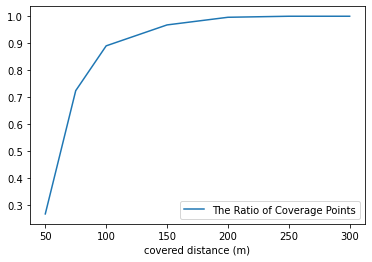

In [94]:
# 반경 별로 교통사고 위험지역을 커버하는 비율을 시각화하였습니다

교통사고위험지역 = pd.DataFrame(교통사고위험지역)
교통사고위험지역.columns = ['covered distance (m)', 'The Ratio of Coverage Points']

교통사고위험지역.plot('covered distance (m)','The Ratio of Coverage Points')
교통사고위험지역

In [95]:
# 정부에서 권고하는 교통사고 다발지역 반경에 대한 기준과 위 표에서 뽑은 데이터를 근거하여 반경을 100m로 설정하였습니다
# 클래스 1st로 교통사고 위험지역을 시각화하였습니다

어린이보호구역외_위험도20_X맵 = pdk.Layer(
    'ScatterplotLayer',
    교통사고위험지역_클래스1,
    get_position='[lon, lat]',
    get_radius='77',
    get_fill_color = '[255, 150*어린이교통사고횟수, 51, 150*어린이교통사고횟수]',
    pickable=True,
    auto_highlight=True
)

맵 = pdk.Deck(layers=[읍면동맵, 어린이보호구역외_위험도20_X맵],
            mapbox_key = "pk.eyJ1IjoiZWR3YXJkcm9uaWMiLCJhIjoiY2trOW9qa2UyMHpyMjJvbngxMXU2Y3gzbSJ9.3ulI8nY1yimd1b4wk6tfKw",
            initial_view_state=view_state)

맵.to_html("어린이보호구역외_위험도20_X맵.html", notebook_display=False)

<img src='https://raw.githubusercontent.com/AIdward/predict-traffic-accident/master/src/어린이보호구역외_위험도20_X맵.PNG'>

In [96]:
## 최적 반경 100m로 설정한 뒤 교통사고 위험지역 20개 산출

df_result_fin = 격자데이터_어린이보호구역외

points = []
for i in df_result_fin['리스트좌표'] :
    points.append(i)

w= []
for i in df_result_fin['어린이교통사고횟수'] :
    w.append(i)

radius = radius = (1/88.74/1000)*100
K = 20
M = 5000

opt_sites_org,f = mclp(np.array(points),K,radius,M,df_result_fin,w,'어린이교통사고횟수')

어린이보호구역외_위험도20 = pd.DataFrame(opt_sites_org)
어린이보호구역외_위험도20.columns = ['lon', 'lat']
어린이보호구역외_위험도20

----- Configurations -----
  Number of points 5297
  K 20
  Radius 0.00112689
  M 5000
----- Output -----
  Running time : 18.654192209243774 seconds
  Optimal coverage points: 52.2752


,lon,lat
0,127.075465,37.148360
1,127.077157,37.147916
2,127.071552,37.143389
3,127.079474,37.136206
4,127.077217,37.137099
5,127.077793,37.134847
6,127.065907,37.146072
7,127.062513,37.148764
8,127.068740,37.142928
9,127.048824,37.178459


- 해결과제1 제출형식에는 위험지역의 주변 시설물까지 넣어야 합니다
- 그러므로 선정한 20개의 위험지역 주변에 시설물이 존재하면 그 시설물 이름을 넣어주어야 하는 코드를 작성하였습니다
- 시설물이 겹칠 때는 시설물의 중요도에 의거하여 데이터를 넣었습니다

In [97]:
# 먼저 COMPAS에서 제공하는 주변시설 데이터를 가져왔습니다
초등학교여부 = pd.read_csv("10.오산시_학교위치정보.csv")
어린이집유치원여부 = pd.read_csv("13.오산시_어린이집_유치원현황.csv")
체육시설여부 = pd.read_csv("29.오산시_체육시설현황.csv")
학원및교습소여부 = pd.read_csv("30.오산시_학원_및_교습소_현황.csv")

In [98]:
# 주변시설물들을 편하게 사용할 수 있게 이전과 다른 형식으로 전처리하여주었습니다
초등학교여부 = 초등학교여부.drop(초등학교여부[초등학교여부['학교구분']!='초등학교'].index).reset_index(drop=True)
초등학교여부 = 초등학교여부.rename(columns = {'학교명':'시설명', '학교위치_경도':'lon', '학교위치_위도':'lat'})
초등학교여부 = 초등학교여부.loc[:,['lon', 'lat','시설명']]
어린이집여부 = 어린이집유치원현황.drop(어린이집유치원현황[어린이집유치원현황['시설구분']!='어린이집'].index).reset_index(drop=True)
어린이집여부 = 어린이집여부.rename(columns = {'시설위치_경도':'lon','시설위치_위도':'lat'})
어린이집여부 = 어린이집여부.loc[:,['lon','lat','시설명']]
유치원여부 = 어린이집유치원현황.drop(어린이집유치원현황[어린이집유치원현황['시설구분']!='유치원'].index).reset_index(drop=True)
유치원여부 = 유치원여부.rename(columns = {'시설위치_경도':'lon','시설위치_위도':'lat'})
유치원여부 = 유치원여부.loc[:,['lon','lat','시설명']]
학원및교습소여부 = 학원및교습소여부.drop(학원및교습소현황[학원및교습소현황['업종구분명']=='평생직업교육학원'].index).reset_index(drop=True)
학원및교습소여부 = 학원및교습소여부.rename(columns = {'교습과정명':'시설명','시설위치_경도':'lon', '시설위치_위도':'lat'})
학원및교습소여부 = 학원및교습소여부.loc[:,['lon', 'lat','시설명']]
체육시설여부 = 체육시설여부.rename(columns = {'시설구분명':'시설명','설치위치_경도':'lon', '설치위치_위도':'lat'})
체육시설여부 = 체육시설여부.loc[:,['lon', 'lat','시설명']]

In [99]:
# 좌표 주변에 시설물이 있으면 어떤 시설이 있는지 알려주는 함수를 만들었습니다
def 격자_시설명(데이터):
    for i in range(len(데이터)):               
        위치 = 어린이보호구역외_위험도20[(어린이보호구역외_위험도20['lon'] <= 데이터.loc[i,'lon']+one_meter*300)&
                            (어린이보호구역외_위험도20['lat'] <= 데이터.loc[i,'lat']+one_meter*300)&
                            (데이터.loc[i,'lon']-one_meter*300 <= 어린이보호구역외_위험도20['lon'])&
                            (데이터.loc[i,'lat']-one_meter*300 <= 어린이보호구역외_위험도20['lat'])
                ].index
        어린이보호구역외_위험도20.loc[위치,'시설명'] = 데이터.loc[i,'시설명']

In [100]:
# 함수를 적용할 때 중요도가 낮은 순으로 시설을 삽입하도록 순서를 정하였습니다
# 이렇게 순서를 정함으로써 더 중요도있는 시설물이 시설명 컬럼에 들어가도록 할 수 있기 때문입니다 
격자_시설명(체육시설여부)
격자_시설명(학원및교습소여부)
격자_시설명(어린이집여부)
격자_시설명(유치원여부)
격자_시설명(초등학교여부)
어린이보호구역외_위험도20

,lon,lat,시설명
0,127.075465,37.148360,꿈이노는어린이집
1,127.077157,37.147916,꿈이노는어린이집
2,127.071552,37.143389,대림어린이집
3,127.079474,37.136206,리틀예지어린이집
4,127.077217,37.137099,리틀예지어린이집
5,127.077793,37.134847,고현천사어린이집
6,127.065907,37.146072,전문제과제빵인양성과정
7,127.062513,37.148764,시립세교행복어린이집
8,127.068740,37.142928,대림햇살어린이집
9,127.048824,37.178459,혜아어린이집


In [101]:
# 해결과제1 제출 형식에 맞게 데이터프레임을 수정하여주었습니다
# 이로써 해결과제1을 완료하였습니다
위험순위 = [i for i in range(1,21)]
해결과제1 = 어린이보호구역외_위험도20.copy()
해결과제1['위험순위']=위험순위
해결과제1['반경범위']='100M'
해결과제1 = 해결과제1.rename(columns={'lon':'x좌표(경도)','lat':'y좌표(위도)'})
해결과제1 = 해결과제1.loc[:,['위험순위','시설명','x좌표(경도)','y좌표(위도)','반경범위']]
해결과제1

,위험순위,시설명,x좌표(경도),y좌표(위도),반경범위
0,1,꿈이노는어린이집,127.075465,37.148360,100M
1,2,꿈이노는어린이집,127.077157,37.147916,100M
2,3,대림어린이집,127.071552,37.143389,100M
3,4,리틀예지어린이집,127.079474,37.136206,100M
4,5,리틀예지어린이집,127.077217,37.137099,100M
5,6,고현천사어린이집,127.077793,37.134847,100M
6,7,전문제과제빵인양성과정,127.065907,37.146072,100M
7,8,시립세교행복어린이집,127.062513,37.148764,100M
8,9,대림햇살어린이집,127.068740,37.142928,100M
9,10,혜아어린이집,127.048824,37.178459,100M


In [102]:
# 최종적으로 도출한 20개의 포인트를 시각화하였습니다
어린이보호구역외_위험도20맵 = pdk.Layer(
    'ScatterplotLayer',
    어린이보호구역외_위험도20,
    get_position='[lon, lat]',
    get_radius='100',
    get_fill_color = '[102, 255, 255]',
    pickable=True,
    auto_highlight=True
)

맵 = pdk.Deck(layers=[읍면동맵, 어린이보호구역외_위험도20맵],
            mapbox_key = "pk.eyJ1IjoiZWR3YXJkcm9uaWMiLCJhIjoiY2trOW9qa2UyMHpyMjJvbngxMXU2Y3gzbSJ9.3ulI8nY1yimd1b4wk6tfKw",
            initial_view_state=view_state)
맵.to_html("어린이보호구역외_위험도20맵.html", notebook_display=False)

<img src='https://raw.githubusercontent.com/AIdward/predict-traffic-accident/master/src/어린이보호구역외_위험도20맵.PNG'>

In [103]:
# 최종적으로 도출한 20개의 포인트가 잘 선정되었는지 시각화를 통해 확인해보았습니다
어린이보호구역외_위험도20맵 = pdk.Layer(
    'ScatterplotLayer',
    어린이보호구역외_위험도20,
    get_position='[lon, lat]',
    get_radius='77',
    get_fill_color = '[102, 255, 255]',
    pickable=True,
    auto_highlight=True
)

맵 = pdk.Deck(layers=[읍면동맵, 어린이보호구역외_위험도20_X맵, 어린이보호구역외_위험도20맵],
            mapbox_key = "pk.eyJ1IjoiZWR3YXJkcm9uaWMiLCJhIjoiY2trOW9qa2UyMHpyMjJvbngxMXU2Y3gzbSJ9.3ulI8nY1yimd1b4wk6tfKw",
            initial_view_state=view_state)
맵.to_html("어린이보호구역외_위험도20맵_최종.html", notebook_display=False)

In [ ]:
격자데이터_어린이보호구역내맵

<img src='https://raw.githubusercontent.com/AIdward/predict-traffic-accident/master/src/어린이보호구역외_위험도20맵_최종.PNG'>

# <a id=3>3. 어린이 보호구역 중 교통안전시설물 우선 설치 지역 20개소 제시 (해결과제2)</a>

# 3-1 어린이 보호구역 91개 중 위험지수가 높은 20곳 선정<a id=3-1></a>

In [104]:
# 어린이보호구역 내에 있는 격자 데이터를 따로 만들었습니다 (해결과제2에서 사용)
격자데이터_어린이보호구역내 = 격자데이터_XGB.drop(
                                격자데이터_XGB[격자데이터_XGB['어린이보호구역']!=1].index).reset_index(drop=True)
격자데이터_어린이보호구역내

,lon,lat,총유동인구,유소년인구비율,초등학교,유치원,어린이집,학원및교습소,체육시설,추정교통량,제한속도,도로신호등,중앙분리대,무인교통단속카메라,과속방지턱,CCTV,어린이교통사고횟수,어린이보호구역
0,127.014457,37.179675,0.008589,0.0,0.000000,0.000000,0.0,0.0,0.0,0.02945,0.090909,0.0,0.0,0.000000,0.0,0.025210,0.009971,1
1,127.014463,37.178774,0.006457,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.033613,0.004426,1
2,127.014468,37.177873,0.004109,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.033613,0.003910,1
3,127.014474,37.176971,0.003111,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.042017,0.003846,1
4,127.014480,37.176070,0.024568,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.042017,0.007514,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3942,127.094077,37.142566,0.004143,0.0,0.285714,0.181818,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.028571,0.0,0.025210,0.002529,1
3943,127.094081,37.141665,0.005633,0.0,0.285714,0.181818,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.028571,0.0,0.025210,0.002787,1
3944,127.094086,37.140764,0.006004,0.0,0.285714,0.181818,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.028571,0.0,0.025210,0.002787,1
3945,127.094091,37.139862,0.003161,0.0,0.285714,0.181818,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.028571,0.0,0.025210,0.002487,1


In [105]:
# 어린이 보호구역 내의 격자를 시각화하였습니다
격자데이터_어린이보호구역내맵 = pdk.Layer(
    'ScatterplotLayer',
    격자데이터_어린이보호구역내,
    get_position='[lon, lat]',
    get_radius='어린이보호구역*30',
    get_fill_color = '[0, 255, 0]',
    pickable=True,
    auto_highlight=True
)

맵 = pdk.Deck(layers=[읍면동맵, 격자데이터_어린이보호구역내맵],
            mapbox_key = "pk.eyJ1IjoiZWR3YXJkcm9uaWMiLCJhIjoiY2trOW9qa2UyMHpyMjJvbngxMXU2Y3gzbSJ9.3ulI8nY1yimd1b4wk6tfKw",
            initial_view_state=view_state)
맵.to_html("격자데이터_어린이보호구역내맵.html", notebook_display=False)

<img src='https://raw.githubusercontent.com/AIdward/predict-traffic-accident/master/src/격자데이터_어린이보호구역내맵.PNG'>

In [106]:
# 어린이보호구역마다 70x70 격자들이 들어있습니다
# 어린이보호구역91개중 20개를 산출해야 하므로 어린이보호구역별 위험도지수를 이용하여 20곳을 산출하였습니다
for i in range(2,16):
    어린이보호구역[격자데이터_어린이보호구역내.columns[i]]=0

In [107]:
격자데이터_어린이보호구역내

,lon,lat,총유동인구,유소년인구비율,초등학교,유치원,어린이집,학원및교습소,체육시설,추정교통량,제한속도,도로신호등,중앙분리대,무인교통단속카메라,과속방지턱,CCTV,어린이교통사고횟수,어린이보호구역
0,127.014457,37.179675,0.008589,0.0,0.000000,0.000000,0.0,0.0,0.0,0.02945,0.090909,0.0,0.0,0.000000,0.0,0.025210,0.009971,1
1,127.014463,37.178774,0.006457,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.033613,0.004426,1
2,127.014468,37.177873,0.004109,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.033613,0.003910,1
3,127.014474,37.176971,0.003111,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.042017,0.003846,1
4,127.014480,37.176070,0.024568,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.042017,0.007514,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3942,127.094077,37.142566,0.004143,0.0,0.285714,0.181818,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.028571,0.0,0.025210,0.002529,1
3943,127.094081,37.141665,0.005633,0.0,0.285714,0.181818,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.028571,0.0,0.025210,0.002787,1
3944,127.094086,37.140764,0.006004,0.0,0.285714,0.181818,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.028571,0.0,0.025210,0.002787,1
3945,127.094091,37.139862,0.003161,0.0,0.285714,0.181818,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.028571,0.0,0.025210,0.002487,1


In [108]:
for i in range(len(어린이보호구역)):
    격자데이터_어린이보호구역내['어린이보호구역']=1
    위치 = 격자데이터_어린이보호구역내[(격자데이터_어린이보호구역내['lon'] <= 어린이보호구역.loc[i,'lon']+one_meter*150)&
                        (격자데이터_어린이보호구역내['lat'] <= 어린이보호구역.loc[i,'lat']+one_meter*150)&
                        (어린이보호구역.loc[i,'lon']-one_meter*150 <= 격자데이터_어린이보호구역내['lon'])&
                        (어린이보호구역.loc[i,'lat']-one_meter*150 <= 격자데이터_어린이보호구역내['lat'])
            ].index
    격자데이터_어린이보호구역내.loc[위치,'어린이보호구역'] = 0
    globals()['어린이보호구역{}'.format(i)] = 격자데이터_어린이보호구역내.drop(격자데이터_어린이보호구역내[격자데이터_어린이보호구역내['어린이보호구역']==1].index).reset_index(drop=True)
    globals()['어린이보호구역{}'.format(i)]['시설명'] = 어린이보호구역.loc[i,'시설명']
    globals()['어린이보호구역{}'.format(i)] = globals()['어린이보호구역{}'.format(i)].sort_values(by = ['어린이교통사고횟수'], axis=0, ascending = False).reset_index(drop=True)
    for j in range(2,16):
        어린이보호구역.loc[i,격자데이터_어린이보호구역내.columns[j]] = globals()['어린이보호구역{}'.format(i)][격자데이터_어린이보호구역내.columns[j]].mean()
        어린이보호구역.loc[i,'위험도평균'] = globals()['어린이보호구역{}'.format(i)]['어린이교통사고횟수'].mean()
어린이보호구역 = 어린이보호구역.sort_values(by = ['위험도평균'], axis=0, ascending = False).reset_index(drop=True)
어린이보호구역_위험도20 = 어린이보호구역.loc[:19]

In [109]:
# 어린이보호구역 91개중 상위 20개들을 선별하였습니다
# 컬럼수가 너무 많으므로 두개로 나누어 출력하였습니다
어린이보호구역_위험도20.iloc[:,:10]

,lon,lat,시설명,총유동인구,유소년인구비율,초등학교,유치원,어린이집,학원및교습소,체육시설
0,127.077534,37.152640,운산초등학교,0.393555,0.570810,0.648810,0.689394,0.773674,0.168027,0.360215
1,127.078219,37.153627,예인유치원,0.431008,0.609520,0.636905,0.757576,0.851326,0.167574,0.297043
2,127.072326,37.138565,시립남부어린이집,0.429686,0.505474,0.607143,0.386364,0.520833,0.644570,0.598118
3,127.071695,37.139203,오산원일초등학교,0.396587,0.488822,0.619048,0.393939,0.550189,0.649106,0.533602
4,127.079762,37.155951,운천초등학교,0.612892,0.569640,0.591837,0.757576,0.810606,0.262682,0.288786
5,127.076416,37.157039,동화마을유치원,0.480764,0.312765,0.363095,0.670455,0.410038,0.211962,0.436828
6,127.071138,37.147119,시립오산어린이집,0.551718,0.151811,0.410714,0.556818,0.129735,0.214684,0.236559
7,127.070577,37.133550,대일유치원,0.285531,0.621348,0.612245,0.541126,0.829004,0.412871,0.729647
8,127.067040,37.150444,성산초등학교,0.276129,0.142981,0.529762,0.579545,0.067235,0.112364,0.272849
9,127.070953,37.150478,성호초등학교,0.353454,0.180436,0.518519,0.696970,0.168350,0.243362,0.379928


In [110]:
어린이보호구역_위험도20.iloc[:,10:]

,추정교통량,제한속도,도로신호등,중앙분리대,무인교통단속카메라,과속방지턱,CCTV,위험도평균
0,0.096303,0.255366,0.178204,0.014881,0.405952,0.127315,0.443627,0.737080
1,0.119446,0.285038,0.161918,0.028274,0.364286,0.127315,0.426821,0.700545
2,0.203488,0.292929,0.224483,0.138095,0.569048,0.187500,0.367647,0.686153
3,0.152817,0.257260,0.342080,0.150000,0.603571,0.180556,0.376401,0.640590
4,0.179577,0.287518,0.230452,0.182653,0.281633,0.145503,0.361745,0.608987
5,0.156358,0.556976,0.380781,0.193750,0.344048,0.101852,0.578081,0.587433
6,0.088407,0.101010,0.290493,0.066964,0.836905,0.289352,0.778711,0.554207
7,0.165530,0.306638,0.093172,0.186565,0.281633,0.119048,0.448179,0.551815
8,0.080680,0.121528,0.181182,0.000000,0.345238,0.273148,0.905462,0.542713
9,0.072171,0.133838,0.301252,0.035714,0.625397,0.277778,0.873638,0.520531


In [111]:
# 어린이보호구역 내에 있는 격자 데이터를 pydeck을 이용하여 시각화하였습니다
어린이보호구역_위험도20맵 = pdk.Layer(
    'ScatterplotLayer',
    어린이보호구역_위험도20,
    get_position='[lon, lat]',
    get_radius='300',
    get_fill_color = '[0, 255, 0]',
    pickable=True,
    auto_highlight=True
)

맵 = pdk.Deck(layers=[읍면동맵, 어린이보호구역_위험도20맵],
            mapbox_key = "pk.eyJ1IjoiZWR3YXJkcm9uaWMiLCJhIjoiY2trOW9qa2UyMHpyMjJvbngxMXU2Y3gzbSJ9.3ulI8nY1yimd1b4wk6tfKw",
            initial_view_state=view_state)
맵.to_html("어린이보호구역_위험도20맵_20개.html", notebook_display=False)

<img src='https://raw.githubusercontent.com/AIdward/predict-traffic-accident/master/src/어린이보호구역_위험도20맵_20개.PNG'>

# 3-2 위험지수가 높은 20곳 각각에서 가장 위험한 곳 특징짓기<a id=3-2></a>

- 어린이보호구역91개중 20개를 구하여도 하나의 어린이보호구역 안에서 각각 격자의 위험도 비율이 다릅니다
- 그러므로 각각의 어린이 보호구역에서 가장 위험한 좌표를 특정짓는 코드를 작성하였습니다

In [112]:
# 어린이보호구역에 포함된 격자와 바깥의 격자를 나누어 주어야 합니다
# 그러므로 COMPAS에서 제공한 어린이보호구역 데이터를 불러왔습니다
어린이보호구역_선별 =  pd.read_csv("9.오산시_어린이보호구역.csv")
어린이보호구역_선별 = 어린이보호구역_선별.rename(columns={'보호구역_경도':'lon','보호구역_위도':'lat'})
어린이보호구역_선별 = 어린이보호구역_선별.loc[:,['lon','lat','시설명']]
# 어린이보호구역마다 70x70 격자들이 들어있습니다
# 어린이보호구역91개중 20개를 산출해야 하므로 어린이보호구역별 위험도지수를 산출하였습니다
for i in range(2,16):
    어린이보호구역_선별[격자데이터_어린이보호구역내.columns[i]]=0

In [113]:
개수 = [i for i in range(0, len(격자데이터_어린이보호구역내))]
어린이보호구역_최대위험 = 격자데이터_어린이보호구역내.drop(개수,0)
어린이보호구역_최대위험['시설명']='None'

In [114]:
어린이보호구역_최대위험 = 격자데이터_어린이보호구역내.drop(개수,0)
for i in range(len(어린이보호구역_선별)):
    격자데이터_어린이보호구역내['어린이보호구역']=1
    위치 = 격자데이터_어린이보호구역내[(격자데이터_어린이보호구역내['lon'] <= 어린이보호구역_선별.loc[i,'lon']+one_meter*150)&
                        (격자데이터_어린이보호구역내['lat'] <= 어린이보호구역_선별.loc[i,'lat']+one_meter*150)&
                        (어린이보호구역_선별.loc[i,'lon']-one_meter*150 <= 격자데이터_어린이보호구역내['lon'])&
                        (어린이보호구역_선별.loc[i,'lat']-one_meter*150 <= 격자데이터_어린이보호구역내['lat'])
            ].index
    격자데이터_어린이보호구역내.loc[위치,'어린이보호구역'] = 0
    globals()['어린이보호구역_선별{}'.format(i)] = 격자데이터_어린이보호구역내.drop(격자데이터_어린이보호구역내[격자데이터_어린이보호구역내['어린이보호구역']==1].index).reset_index(drop=True)
    globals()['어린이보호구역_선별{}'.format(i)]['시설명'] = 어린이보호구역_선별.loc[i,'시설명']
    globals()['어린이보호구역_선별{}'.format(i)] = globals()['어린이보호구역_선별{}'.format(i)].sort_values(by = ['어린이교통사고횟수'], axis=0, ascending = False).reset_index(drop=True)
    어린이보호구역_최대위험 = pd.concat([어린이보호구역_최대위험,globals()['어린이보호구역_선별{}'.format(i)].loc[[0]]]).reset_index(drop=True)
    for j in range(2,16):
        어린이보호구역_선별.loc[i,격자데이터_어린이보호구역내.columns[j]] = globals()['어린이보호구역_선별{}'.format(i)][격자데이터_어린이보호구역내.columns[j]].mean()
        어린이보호구역_선별.loc[i,'위험도평균'] = globals()['어린이보호구역_선별{}'.format(i)]['어린이교통사고횟수'].mean()
어린이보호구역_선별 = 어린이보호구역_선별.sort_values(by = ['위험도평균'], axis=0, ascending = False)
어린이보호구역_위험도20선별 = 어린이보호구역_선별[:20]
어린이보호구역_위험도71선별 = 어린이보호구역_선별[20:]

In [115]:
어린이보호구역_위험도20_특정지역 = 어린이보호구역_최대위험.drop(어린이보호구역_위험도71선별.index).reset_index(drop=True)

In [116]:
# 91개중 가장 위험한 순으로 20개를 나열한 곳 중, 20개 각각의 어린이보호구역에서 가장 위험한 격자를 도출해내었습니다
어린이보호구역_위험도20_특정지역

,lon,lat,총유동인구,유소년인구비율,초등학교,유치원,어린이집,학원및교습소,체육시설,추정교통량,제한속도,도로신호등,중앙분리대,무인교통단속카메라,과속방지턱,CCTV,어린이교통사고횟수,어린이보호구역,시설명
0,127.058512,37.159115,0.262134,0.091222,0.714286,0.454545,0.136364,0.195956,0.419355,0.042250,0.075758,0.551487,0.014286,0.742857,0.500000,0.941176,0.522370,0,대호초등학교
1,127.066452,37.149229,0.251112,0.167213,0.571429,0.545455,0.022727,0.115086,0.225806,0.079352,0.106061,0.470924,0.000000,0.285714,0.222222,0.865546,0.671978,0,성산초등학교
2,127.072648,37.148801,0.545486,0.256851,0.571429,0.727273,0.250000,0.626750,0.483871,0.199029,0.121212,0.580986,0.214286,0.828571,0.277778,0.798319,0.720976,0,성호초등학교
3,127.073264,37.139338,0.501100,0.430236,0.571429,0.363636,0.431818,0.709176,0.709677,0.317793,0.431818,0.287192,0.164286,0.600000,0.277778,0.361345,0.776127,0,오산원일초등학교
4,127.076576,37.151069,0.527990,0.457398,0.571429,0.545455,0.590909,0.351477,0.580645,0.061293,0.204545,0.334003,0.000000,0.542857,0.111111,0.470588,0.913720,0,운산초등학교
5,127.078809,37.154682,0.544797,0.644597,0.714286,0.909091,0.931818,0.241058,0.290323,0.068633,0.219697,0.268861,0.050000,0.285714,0.111111,0.386555,0.802972,0,운천초등학교
6,127.071032,37.135725,0.359126,0.664269,0.571429,0.454545,0.772727,0.474339,0.741935,0.098843,0.265152,0.000000,0.000000,0.257143,0.111111,0.403361,0.693043,0,원동초등학교
7,127.070477,37.134370,0.337147,0.628512,0.714286,0.545455,0.795455,0.517885,0.903226,0.094770,0.295455,0.000000,0.000000,0.314286,0.055556,0.428571,0.637458,0,대일유치원
8,127.077682,37.154678,0.455951,0.635385,0.714286,0.909091,0.977273,0.241058,0.290323,0.100685,0.378788,0.268861,0.050000,0.285714,0.166667,0.453782,0.819428,0,예인유치원
9,127.069810,37.152847,0.257324,0.187503,0.571429,0.636364,0.136364,0.088647,0.225806,0.017178,0.030303,0.000000,0.000000,0.428571,0.222222,0.890756,0.537350,0,오산유치원


# 3-3 시설물우선설치지수 도출<a id=3-3></a>

**어린이보호구역에 어떤 시설물을 설치해야하는지 구하기 위해 시설물우선설치지수를 도입합니다**

- Scikit-learn 머신러닝을 활용하면 변수 중요도가 디폴트이기 때문에 알 수 있다
- 하지만 변수 중요도는 음양관계를 알 수 없기 때문에 음양관계까지 포함한 피어슨 상관계수도 고려해서
- 글로벌 가중치와 국소적 가중치, 그리고 시설물부족도 변수를 계산해줍니다

### (1) 글로벌 가중치(Global) : 오산시 전체에 대해 학습한 머신러닝을 기준으로 판단한 가중치<a id=3-3-1></a>

- 교통사고 위험도와 시설물 간의 양의 상관관계와 음의 상관관계를 동시에 고려할 필요가 있습니다
- 교통사고 위험도와 양의 상관관계를 갖는 시설물은 개수가 늘어도 교통사고 완화에 도움이 미비하다고 판단해 이에 대한 가중치를 줄이고, 음의 상관관계를 갖는 시설물의 가중치를 높이는 방식으로 수식을 설정했습니다
- 글로벌 가중치를 산정하기 위해 글로벌 계수1,2를 도입했습니다
- 글로벌 계수1 = - 글로벌 피어슨 상관계수 x 글로벌 변수 중요도
- 글로벌 계수2 = max(글로벌 계수1) - 글로벌 계수1
- 글로벌 가중치 = max(글로벌 계수2)/(글로벌 계수2 + 0.1)
- 최종 글로벌 가중치는 1(오산시) x 4(교통안전시설물변수개수) 형태로 도출됩니다

In [117]:
# 튜닝으로 구한 파라마터로 XGBoost 다시 예측을 진행했습니다
# 시설물에 대한 가중치를 구하기 위해 시설물 데이터만 선별해 예측을 진행합니다

X = 격자데이터.loc[:,'중앙분리대':'CCTV']
y = 격자데이터.loc[:, "어린이교통사고횟수"]
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1, test_size=0.2)

XGBmodel = xgboost.XGBRegressor(booster='gbtree',
                 max_depth=8,
                 min_child_weight=1,
                 gamma=0,
                 nthread=4,
                 colsample_bytree=0.8,
                 colsample_bylevel=0.9,
                 n_estimators=50,
                 objective='binary:logistic',
                 random_state=2)
XGBmodel.fit(X_train,y_train)
y_pred = XGBmodel.predict(X)

격자데이터_XGB_시설 = 격자데이터.copy()
격자데이터_XGB_시설['어린이교통사고횟수'] = y_pred
격자데이터_XGB_시설

,lon,lat,총유동인구,유소년인구비율,초등학교,유치원,어린이집,학원및교습소,체육시설,추정교통량,제한속도,도로신호등,중앙분리대,무인교통단속카메라,과속방지턱,CCTV,어린이교통사고횟수
0,126.994192,37.177788,0.006220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003028
1,126.994198,37.176887,0.006304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003028
2,126.994204,37.175985,0.002699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003028
3,126.994210,37.175084,0.001760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003028
4,126.994216,37.174182,0.000700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9239,127.103080,37.143498,0.000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003028
9240,127.103631,37.145754,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003028
9241,127.103636,37.144852,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003028
9242,127.103640,37.143951,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003028


In [118]:
# XGBoost 모델로부터 피어슨상관계수를 뽑아내었습니다
피어슨상관계수_글로벌 = 격자데이터_XGB_시설.loc[:,"중앙분리대":"어린이교통사고횟수"]
피어슨상관계수_글로벌 = 피어슨상관계수_글로벌.corr(method = 'pearson')
피어슨상관계수_글로벌

,중앙분리대,무인교통단속카메라,과속방지턱,CCTV,어린이교통사고횟수
중앙분리대,1.000000,0.181636,0.129578,0.208703,0.312646
무인교통단속카메라,0.181636,1.000000,0.610740,0.840759,0.787598
과속방지턱,0.129578,0.610740,1.000000,0.657406,0.552354
CCTV,0.208703,0.840759,0.657406,1.000000,0.832716
어린이교통사고횟수,0.312646,0.787598,0.552354,0.832716,1.000000


In [119]:
격자데이터_XGB_시설

,lon,lat,총유동인구,유소년인구비율,초등학교,유치원,어린이집,학원및교습소,체육시설,추정교통량,제한속도,도로신호등,중앙분리대,무인교통단속카메라,과속방지턱,CCTV,어린이교통사고횟수
0,126.994192,37.177788,0.006220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003028
1,126.994198,37.176887,0.006304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003028
2,126.994204,37.175985,0.002699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003028
3,126.994210,37.175084,0.001760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003028
4,126.994216,37.174182,0.000700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9239,127.103080,37.143498,0.000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003028
9240,127.103631,37.145754,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003028
9241,127.103636,37.144852,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003028
9242,127.103640,37.143951,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003028


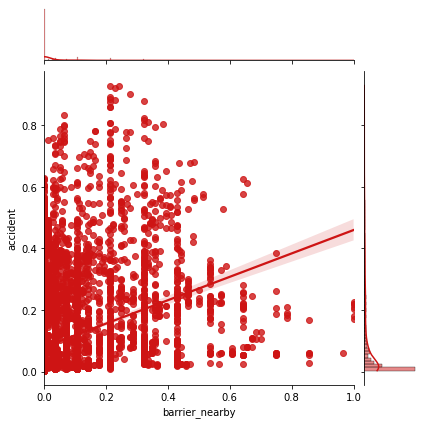

In [120]:
# 다변수-다변수 데이터 간의 상관관계 시각화한 것 중 하나를 확대하여 시각화하였습니다
격자데이터_XGB_시설2 = 격자데이터_XGB_시설.copy()
격자데이터_XGB_시설2 = 격자데이터_XGB_시설2.rename({'중앙분리대':'barrier_nearby', '어린이교통사고횟수':'accident'}, axis='columns')
sns.jointplot(격자데이터_XGB_시설2.loc[:,'barrier_nearby'], 격자데이터_XGB_시설2.loc[:,'accident'], kind="reg", color="#ce1414")
plt.show()

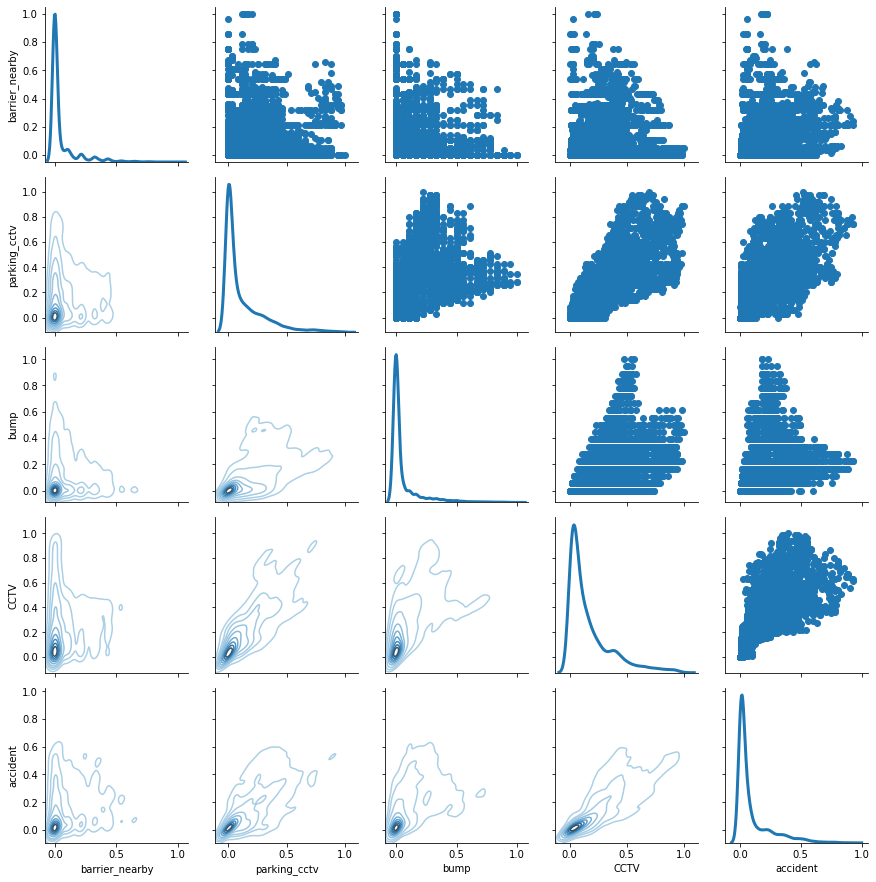

In [121]:
# 다변수-다변수 데이터 간의 상관관계 시각화하였습니다
격자데이터_XGB_시설3 = 격자데이터_XGB_시설.iloc[:,12:17]
격자데이터_XGB_시설3 = 격자데이터_XGB_시설3.rename({'중앙분리대':'barrier_nearby', '무인교통단속카메라':'parking_cctv',
                                      '과속방지턱':'bump', '어린이교통사고횟수':'accident'}, axis='columns')
g = sns.PairGrid(격자데이터_XGB_시설3, diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

In [122]:
# 글로벌가중치를 얻기 위해 데이터프레임을 잘 정리하였습니다
# 계산의 편의성을 위해 글로벌 피어슨상관계수를 array형태로도 만들어놓았습니다
피어슨상관계수_글로벌 = 피어슨상관계수_글로벌.loc[['어린이교통사고횟수'],:]
del 피어슨상관계수_글로벌['어린이교통사고횟수']
피어슨상관계수_글로벌 = 피어슨상관계수_글로벌.rename(index={'어린이교통사고횟수':'피어슨상관계수_글로벌'})
피어슨상관계수_글로벌np = np.array(피어슨상관계수_글로벌)
피어슨상관계수_글로벌np = 피어슨상관계수_글로벌np.reshape(1,-1)
피어슨상관계수_글로벌np

array([[0.31264571, 0.78759815, 0.55235371, 0.83271568]])

In [123]:
# 글로벌 피어슨상관계수를 데이터프레임형식으로 출력해보았습니다
피어슨상관계수_글로벌_DataFrame = pd.DataFrame(피어슨상관계수_글로벌np)
피어슨상관계수_글로벌_DataFrame = 피어슨상관계수_글로벌_DataFrame.rename(columns={0:'중앙분리대',1:'무인교통단속카메라',2:'과속방지턱',3:'CCTV'},index={0:'피어슨상관계수_글로벌'})
피어슨상관계수_글로벌_DataFrame

,중앙분리대,무인교통단속카메라,과속방지턱,CCTV
피어슨상관계수_글로벌,0.312646,0.787598,0.552354,0.832716


In [124]:
# array형태의 글로벌 변수중요도를 만들었습니다
변수중요도_글로벌np = XGBmodel.feature_importances_
변수중요도_글로벌np = 변수중요도_글로벌np.reshape(1,-1)
변수중요도_글로벌np

array([[0.09662326, 0.21198867, 0.24169457, 0.44969353]], dtype=float32)

In [125]:
# 글로벌 피어슨상관계수를 데이터프레임형식으로 출력해보았습니다
변수중요도_글로벌_DataFrame = pd.DataFrame(변수중요도_글로벌np)
변수중요도_글로벌_DataFrame = 변수중요도_글로벌_DataFrame.rename(columns={0:'중앙분리대',1:'무인교통단속카메라',2:'과속방지턱',3:'CCTV'},index={0:'변수중요도_글로벌'})
변수중요도_글로벌_DataFrame

,중앙분리대,무인교통단속카메라,과속방지턱,CCTV
변수중요도_글로벌,0.096623,0.211989,0.241695,0.449694


In [126]:
# 글로벌가중치를 식을 통해 계산하였습니다
피어슨상관계수_글로벌np_음수 = -피어슨상관계수_글로벌np
글로벌가중치np_first = 피어슨상관계수_글로벌np_음수 * 변수중요도_글로벌np
M = 글로벌가중치np_first.max()
N = M-글로벌가중치np_first
글로벌가중치np_final =N.max()/[(N)+0.1]
글로벌가중치np_final = 글로벌가중치np_final.reshape(1,-1)
글로벌가중치np_final

array([[3.4425801 , 1.45408063, 1.69341603, 0.77490558]])

In [127]:
# 최종적으로 도출된 글로벌 가중치를 DataFrame형식으로 출력하였습니다
글로벌가중치_DataFrame = pd.DataFrame(글로벌가중치np_final)
글로벌가중치_DataFrame = 글로벌가중치_DataFrame.rename(columns={0:'중앙분리대',1:'무인교통단속카메라',2:'과속방지턱',3:'CCTV'},index={0:'글로벌가중치'})
글로벌가중치_DataFrame

,중앙분리대,무인교통단속카메라,과속방지턱,CCTV
글로벌가중치,3.44258,1.454081,1.693416,0.774906


### (2) 국소적 가중치(Global) : 선별된 어린이보호구역 20곳마다 학습한 머신러닝을 기준으로 판단한 가중치<a id=3-3-2></a>

- 교통사고 위험도와 시설물 간의 양의 상관관계와 음의 상관관계를 동시에 고려할 필요가 있습니다
- 글로벌 가중치와 마찬가지로 교통사고 위험도와 양의 상관관계를 갖는 시설물은 개수가 늘어도 교통사고 완화에 도움이 미비하다고 판단해 이에 대한 가중치를 줄이고, 음의 상관관계를 갖는 시설물의 가중치를 높이는 방식으로 수식을 설정했습니다
- 국소적 가중치를 산정하기 위해 국소적 계수1,2를 도입했습니다
- 국소적 계수1 = - 국소적 피어슨 상관계수 x 국소적 변수 중요도
- 국소적 계수2 = max(국소적 계수1) - 국소적 계수1
- 국소적 가중치 = max(국소적 계수2)/(국소적 계수2 + 0.1)
- 최종 국소적 가중치는 20(선정된 어린이보호구역 개수) x 4(교통안전시설물변수개수) 형태로 도출됩니다

In [128]:
# 국소적 가중치를 도출하기 위해서는 선별된 어린이보호구역20곳 각각을 시설물 변수를 이용해 머신러닝을 학습시켜야합니다
어린이보호구역_국소 =  pd.read_csv("9.오산시_어린이보호구역.csv")
어린이보호구역_국소 = 어린이보호구역_국소.rename(columns={'보호구역_경도':'lon','보호구역_위도':'lat'})
어린이보호구역_국소 = 어린이보호구역_국소.loc[:,['lon','lat','시설명']]
# 격자데이터가 어린이보호구역 안에 있는지 여부를 알아내기 위해 미리 만들어놓은 함수를 사용하였습니다
격자_어린이보호구역(어린이보호구역_국소)

In [129]:
어린이보호구역_국소_어린이보호구역내 = 격자데이터.copy()
어린이보호구역_국소_어린이보호구역내

,lon,lat,총유동인구,유소년인구비율,초등학교,유치원,어린이집,학원및교습소,체육시설,추정교통량,제한속도,도로신호등,중앙분리대,무인교통단속카메라,과속방지턱,CCTV,어린이교통사고횟수
0,126.994192,37.177788,0.006220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,126.994198,37.176887,0.006304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,126.994204,37.175985,0.002699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,126.994210,37.175084,0.001760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,126.994216,37.174182,0.000700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9239,127.103080,37.143498,0.000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9240,127.103631,37.145754,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9241,127.103636,37.144852,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9242,127.103640,37.143951,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [130]:
# 격자데이터_XGB 데이터에 어린이보호구역 내외 여부 변수를 넣어주었습니다
어린이보호구역_국소_어린이보호구역내['어린이보호구역'] = 격자_조밀한격자['어린이보호구역']
# 어린이보호구역 외에 있는 격자 데이터를 따로 만들었습니다 (해결과제1에서 사용)
어린이보호구역_국소_어린이보호구역내 = 어린이보호구역_국소_어린이보호구역내.drop(
                                어린이보호구역_국소_어린이보호구역내[어린이보호구역_국소_어린이보호구역내['어린이보호구역']!=1].index).reset_index(drop=True)
어린이보호구역_국소_어린이보호구역내

,lon,lat,총유동인구,유소년인구비율,초등학교,유치원,어린이집,학원및교습소,체육시설,추정교통량,제한속도,도로신호등,중앙분리대,무인교통단속카메라,과속방지턱,CCTV,어린이교통사고횟수,어린이보호구역
0,127.014457,37.179675,0.008589,0.0,0.000000,0.000000,0.0,0.0,0.0,0.02945,0.090909,0.0,0.0,0.000000,0.0,0.025210,0.0,1
1,127.014463,37.178774,0.006457,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.033613,0.0,1
2,127.014468,37.177873,0.004109,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.033613,0.0,1
3,127.014474,37.176971,0.003111,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.042017,0.0,1
4,127.014480,37.176070,0.024568,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.042017,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3942,127.094077,37.142566,0.004143,0.0,0.285714,0.181818,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.028571,0.0,0.025210,0.0,1
3943,127.094081,37.141665,0.005633,0.0,0.285714,0.181818,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.028571,0.0,0.025210,0.0,1
3944,127.094086,37.140764,0.006004,0.0,0.285714,0.181818,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.028571,0.0,0.025210,0.0,1
3945,127.094091,37.139862,0.003161,0.0,0.285714,0.181818,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.028571,0.0,0.025210,0.0,1


In [131]:
# 어린이보호구역마다 70x70 격자들이 들어있습니다
# 어린이보호구역91개중 20개를 산출해야 하므로 어린이보호구역별 위험도지수를 산출하였습니다
for i in range(2,17):
    어린이보호구역_국소[어린이보호구역_국소_어린이보호구역내.columns[i]]=0

In [132]:
# 어린이보호구역_국소 데이터프레임에 모델을 돌리기 전 격자데이터 값들을 집어넣어줍니다
# 이제 어린이보호구역_국소 데이터에는 어린이보호구역91개가 각 변수들의 평균데이터를 모두 가집니다
for i in range(len(어린이보호구역_국소)):
    어린이보호구역_국소_어린이보호구역내['어린이보호구역']=1
    위치 = 어린이보호구역_국소_어린이보호구역내[(어린이보호구역_국소_어린이보호구역내['lon'] <= 어린이보호구역_국소.loc[i,'lon']+one_meter*150)&
                        (어린이보호구역_국소_어린이보호구역내['lat'] <= 어린이보호구역_국소.loc[i,'lat']+one_meter*150)&
                        (어린이보호구역_국소.loc[i,'lon']-one_meter*150 <= 어린이보호구역_국소_어린이보호구역내['lon'])&
                        (어린이보호구역_국소.loc[i,'lat']-one_meter*150 <= 어린이보호구역_국소_어린이보호구역내['lat'])
            ].index
    어린이보호구역_국소_어린이보호구역내.loc[위치,'어린이보호구역'] = 0
    globals()['어린이보호구역_국소{}'.format(i)] = 어린이보호구역_국소_어린이보호구역내.drop(어린이보호구역_국소_어린이보호구역내[어린이보호구역_국소_어린이보호구역내['어린이보호구역']==1].index).reset_index(drop=True)
    globals()['어린이보호구역_국소{}'.format(i)]['시설명'] = 어린이보호구역_국소.loc[i,'시설명']
    for j in range(2,17):
        어린이보호구역_국소.loc[i,어린이보호구역_국소_어린이보호구역내.columns[j]] = globals()['어린이보호구역_국소{}'.format(i)][어린이보호구역_국소_어린이보호구역내.columns[j]].mean()

In [133]:
# 국소적 가중치를 구하기 위해 어린이보호구역20개의 피어슨상관계수와 변수중요도를 모두 구하는 식을 만들었습니다
# 각 어린이보호구역들을 14개의 변수들을 이용하여 XGBoost를 돌려 각각의 가중치를 구할 수 있습니다 
# 모든 상관계수들은 nparray 20(어린이보호구역 개수)x14(변수의 개수)로 구하여 계산이 편리하도록 하였습니다
피어슨상관계수_국소적np = np.zeros((20,4))
변수중요도_국소적np = np.zeros((20,4))
국소적가중치np = np.zeros((20,4))
for i in range(20):
    X = globals()['어린이보호구역_국소{}'.format(i)].loc[:,'중앙분리대':'CCTV']
    y = globals()['어린이보호구역_국소{}'.format(i)].loc[:,'어린이교통사고횟수']
    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1, test_size=0.2)
    XGBmodel = xgboost.XGBRegressor()
    XGBmodel.fit(X_train,y_train)
    y_pred = XGBmodel.predict(X_test)
    XX = globals()['어린이보호구역_국소{}'.format(i)].loc[:,"중앙분리대":"어린이교통사고횟수"]
    피어슨상관계수_국소적 = XX.corr(method = 'pearson')
    피어슨상관계수_국소적 = 피어슨상관계수_국소적.loc[['어린이교통사고횟수'],:]
    del 피어슨상관계수_국소적['어린이교통사고횟수']
    피어슨상관계수_국소적np[i] = np.array(피어슨상관계수_국소적)
    변수중요도_국소적np[i] = XGBmodel.feature_importances_

In [134]:
# 국소적 피어슨상관계수를 데이터프레임으로 시각화하였습니다
피어슨상관계수_국소적_DataFrame = pd.DataFrame(피어슨상관계수_국소적np)
피어슨상관계수_국소적_DataFrame.columns = 피어슨상관계수_글로벌.columns
피어슨상관계수_국소적_DataFrame = 피어슨상관계수_국소적_DataFrame.fillna(0)
피어슨상관계수_국소적_DataFrame

,중앙분리대,무인교통단속카메라,과속방지턱,CCTV
0,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.857875,0.000000,0.881115
2,-0.343163,0.753984,0.000000,0.471591
3,-0.243055,-0.452092,0.467697,-0.286376
4,-0.378449,0.451119,-0.378304,0.673521
5,0.485517,0.452785,0.000000,-0.207755
6,0.000000,-0.149684,-0.137910,-0.290980
7,0.836309,0.786976,-0.248534,-0.822926
8,-0.569158,0.602866,0.418744,0.678094
9,0.314371,0.667922,0.000000,0.757319


In [135]:
# 국소적 변수중요도를 데이터프레임으로 시각화하였습니다
변수중요도_국소적_DataFrame = pd.DataFrame(변수중요도_국소적np)
변수중요도_국소적_DataFrame.columns = 피어슨상관계수_글로벌.columns
변수중요도_국소적_DataFrame = 변수중요도_국소적_DataFrame.fillna(0)
변수중요도_국소적_DataFrame

,중앙분리대,무인교통단속카메라,과속방지턱,CCTV
0,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.864059,0.000000,0.135941
2,0.153171,0.481169,0.000000,0.365660
3,0.088075,0.056258,0.796210,0.059457
4,0.012405,0.352677,0.361784,0.273133
5,0.626574,0.281696,0.000000,0.091730
6,0.000000,0.310256,0.452076,0.237669
7,0.098899,0.858311,0.017098,0.025692
8,0.238636,0.225658,0.333222,0.202484
9,0.704657,0.109009,0.000000,0.186334


In [136]:
# 국소적 피어슨상관계수를 array형태로 만들어놓아 계산의 편의성을 도모하였습니다
피어슨상관계수_국소적np = np.array(피어슨상관계수_국소적_DataFrame)

In [137]:
# 국소적 변수중요도를 array형태로 만들어놓아 계산의 편의성을 도모하였습니다
변수중요도_국소적np = np.array(변수중요도_국소적_DataFrame)
변수중요도_국소적np[변수중요도_국소적np<0.001] = 0.001

In [138]:
# 국소적가중치를 식을 통해 계산하였습니다
피어슨상관계수_국소적np_음수 = -피어슨상관계수_국소적np
국소적가중치np_first = 피어슨상관계수_국소적np_음수 * 변수중요도_국소적np
국소적가중치np_final = np.zeros((20,4))
for i in range(len(국소적가중치np_first)):
    M = 국소적가중치np_first[i].max()
    N = M-국소적가중치np_first[i]
    국소적가중치np_final[i]=N.max()/[(N)+0.1]

In [139]:
# 최종적으로 도출된 국소적 가중치를 DataFrame형식으로 출력하였습니다
국소적가중치_DataFrame = pd.DataFrame(국소적가중치np_final)
국소적가중치_DataFrame

,0,1,2,3
0,0.000000,0.000000,0.000000,0.000000
1,7.412552,0.881130,7.412552,3.372727
2,4.153566,0.805960,2.722531,1.278003
3,3.824190,3.978189,0.799124,3.669681
4,1.381859,0.810241,3.208258,0.762372
5,0.763744,1.310880,2.715242,3.232698
6,0.408833,0.563550,0.647470,0.691568
7,3.417239,0.874468,5.959406,6.966122
8,2.753562,0.740478,0.733586,0.737973
9,0.688981,1.281897,2.215241,0.918752


### (3) 시설물 부족도 : 선별된 어린이보호구역20곳마다의 부족한 시설물에 관련된 값 <a id=3-3-3></a>

- 시설물 개수로만 판단하기엔 시설물 개수가 높을수록 낮은 가중치를 할당해야 하기 때문에 부족도라는 개념을 도입하였습니다

In [140]:
# 시설물 부족도 array초기값을 선정하였습니다
시설물np = np.zeros((20,4))
시설물부족도np = np.zeros((20,4))

In [141]:
시설이름 = 어린이보호구역_위험도20['시설명'].values.tolist()
for i in range(len(어린이보호구역_국소)):
    if 어린이보호구역_국소.loc[i,'시설명'] not in 시설이름:
        어린이보호구역_국소 = 어린이보호구역_국소.drop(i)
어린이보호구역_국소 = 어린이보호구역_국소.sort_values(by=['어린이교통사고횟수'],ascending=False).reset_index(drop=True)

In [142]:
for i in range(len(어린이보호구역_국소)):
    시설물np[i] = [어린이보호구역_국소.loc[i,'중앙분리대'],어린이보호구역_국소.loc[i,'무인교통단속카메라'],어린이보호구역_국소.loc[i,'과속방지턱'],어린이보호구역_국소.loc[i,'CCTV']]                                             

In [143]:
# 시설물이 아예 없는 곳은 0.01값을 주어 Nan값이 나오는 것을 방지하였습니다
시설물np[시설물np<0.01] = 0.01
for i in range(len(시설물np)):
    for j in range(len(시설물np[i])):
        시설물부족도np[i][j] = 시설물np[i].sum()/시설물np[i][j]

In [144]:
# 최종 시설물 부족도 변수를 DataFrame을 통해 출력하였습니다
시설물부족도 = pd.DataFrame(시설물부족도np)
시설물부족도 = 시설물부족도.rename(columns={0:'중앙분리대',1:'무인교통단속카메라',2:'과속방지턱',3:'CCTV'})
시설물부족도

,중앙분리대,무인교통단속카메라,과속방지턱,CCTV
0,66.647320,2.443084,7.789947,2.235605
1,33.483110,2.598771,7.435859,2.218016
2,9.140720,2.218250,6.732213,3.433429
3,8.736850,2.171288,7.258306,3.481736
4,6.285062,3.539425,11.955901,2.106504
5,5.319008,3.449646,6.677082,2.685687
6,153.384843,4.442871,5.615445,1.693995
7,29.447524,2.356221,6.814998,2.532302
8,5.549949,3.676506,8.697563,2.310290
9,8.297603,3.615928,9.807997,1.996122


### (4) 시설물우선설치지수 : 어린이보호구역에 우선 설치해야하는 시설물을 도출할 수 있는 변수<a id=3-3-4></a>

- 시설물우선설치지수 = 글로벌가중치 * 국소적가중치 * 시설물부족도

In [145]:
글로벌가중치np_final = np.tile(글로벌가중치np_final, (20,1))

In [146]:
# 시설물우선설치지수
시설물우선설치지수np = 글로벌가중치np_final * 국소적가중치np_final * 시설물부족도np
시설물우선설치지수np_정규화 = 정규화.fit_transform(시설물우선설치지수np)
시설물우선설치지수 = pd.DataFrame(시설물우선설치지수np_정규화)
시설물우선설치지수.columns = 피어슨상관계수_글로벌.columns
시설물우선설치지수

,중앙분리대,무인교통단속카메라,과속방지턱,CCTV
0,0.000000,0.000000,0.000000,0.000000
1,0.191935,0.088770,0.547653,0.424072
2,0.029360,0.069308,0.182111,0.248744
3,0.025838,0.334859,0.057631,0.724299
4,0.006716,0.111175,0.381117,0.091038
5,0.003142,0.175306,0.180136,0.492169
6,0.048494,0.097063,0.036125,0.066411
7,0.077819,0.079877,0.403529,1.000000
8,0.011818,0.105537,0.063395,0.096650
9,0.004421,0.179693,0.215878,0.103963


In [147]:
# 시설물우선설치지수 데이터에 주변 시설 데이터를 포함시켜주었습니다
시설물우선설치지수['비고'] = '비고'
for i in range(len(시설물우선설치지수)):
    if 시설물우선설치지수np_정규화[i].max()==시설물우선설치지수.iloc[i,0]:
        시설물우선설치지수.loc[i,'비고'] = '중앙분리대'
    elif 시설물우선설치지수np_정규화[i].max()==시설물우선설치지수.iloc[i,1]:
        시설물우선설치지수.loc[i,'비고'] = '무인교통단속카메라'
    elif 시설물우선설치지수np_정규화[i].max()==시설물우선설치지수.iloc[i,2]:
        시설물우선설치지수.loc[i,'비고'] = '과속방지턱'
    elif 시설물우선설치지수np_정규화[i].max()==시설물우선설치지수.iloc[i,3]:
        시설물우선설치지수.loc[i,'비고'] = 'CCTV'

# 3-4 시설물우선설치지수를 이용한 시설물 삽입<a id=3-4></a>

In [148]:
# # 해결과제2 제출 형식에 맞게 데이터프레임을 수정하여주었습니다
해결과제2 = pd.concat([어린이보호구역_위험도20_특정지역,시설물우선설치지수],axis=1, join='inner')
위험순위 = [i for i in range(1,21)]
해결과제2['위험순위']= 위험순위
해결과제2 = 해결과제2.loc[:,['위험순위','시설명','lon','lat','비고']]
해결과제2 = 해결과제2.rename(columns={'lon':'x_경도','lat':'y_위도'})
해결과제2

,위험순위,시설명,x_경도,y_위도,비고
0,1,대호초등학교,127.058512,37.159115,중앙분리대
1,2,성산초등학교,127.066452,37.149229,과속방지턱
2,3,성호초등학교,127.072648,37.148801,CCTV
3,4,오산원일초등학교,127.073264,37.139338,CCTV
4,5,운산초등학교,127.076576,37.151069,과속방지턱
5,6,운천초등학교,127.078809,37.154682,CCTV
6,7,원동초등학교,127.071032,37.135725,무인교통단속카메라
7,8,대일유치원,127.070477,37.134370,CCTV
8,9,예인유치원,127.077682,37.154678,무인교통단속카메라
9,10,오산유치원,127.069810,37.152847,과속방지턱


In [149]:
시설물우선설치_시설설치 = 해결과제2.copy()
가중치 = [i for i in range(30,10,-1)]
시설물우선설치_시설설치['가중치'] = 가중치

In [150]:
시설물우선설치_중앙분리대 = 시설물우선설치_시설설치.drop(시설물우선설치_시설설치.loc[시설물우선설치_시설설치['비고']!='중앙분리대'].index, inplace=False).reset_index(drop=True)
시설물우선설치_중앙분리대

,위험순위,시설명,x_경도,y_위도,비고,가중치
0,1,대호초등학교,127.058512,37.159115,중앙분리대,30
1,12,시립가온어린이집,127.077667,37.157382,중앙분리대,19
2,13,청원어린이집,127.073738,37.155115,중앙분리대,18
3,18,아이사랑어린이집,127.071598,37.135276,중앙분리대,13


In [151]:
시설물우선설치_과속방지턱 = 시설물우선설치_시설설치.drop(시설물우선설치_시설설치.loc[시설물우선설치_시설설치['비고']!='과속방지턱'].index, inplace=False).reset_index(drop=True)
시설물우선설치_과속방지턱

,위험순위,시설명,x_경도,y_위도,비고,가중치
0,2,성산초등학교,127.066452,37.149229,과속방지턱,29
1,5,운산초등학교,127.076576,37.151069,과속방지턱,26
2,10,오산유치원,127.069810,37.152847,과속방지턱,21
3,16,하얀뜰어린이집,127.071048,37.133020,과속방지턱,15
4,17,그린어린이집,127.068709,37.148336,과속방지턱,14


In [152]:
시설물우선설치_무인교통단속카메라 = 시설물우선설치_시설설치.drop(시설물우선설치_시설설치.loc[시설물우선설치_시설설치['비고']!='무인교통단속카메라'].index, inplace=False).reset_index(drop=True)
시설물우선설치_무인교통단속카메라

,위험순위,시설명,x_경도,y_위도,비고,가중치
0,7,원동초등학교,127.071032,37.135725,무인교통단속카메라,24
1,9,예인유치원,127.077682,37.154678,무인교통단속카메라,22
2,11,동화마을유치원,127.077677,37.155580,무인교통단속카메라,20
3,14,시립오산어린이집,127.072653,37.147900,무인교통단속카메라,17
4,15,시립비둘기어린이집,127.071037,37.134823,무인교통단속카메라,16
5,19,아이마루어린이집,127.071048,37.133020,무인교통단속카메라,12


In [153]:
시설물우선설치_CCTV = 시설물우선설치_시설설치.drop(시설물우선설치_시설설치.loc[시설물우선설치_시설설치['비고']!='CCTV'].index, inplace=False).reset_index(drop=True)
시설물우선설치_CCTV

,위험순위,시설명,x_경도,y_위도,비고,가중치
0,3,성호초등학교,127.072648,37.148801,CCTV,28
1,4,오산원일초등학교,127.073264,37.139338,CCTV,27
2,6,운천초등학교,127.078809,37.154682,CCTV,25
3,8,대일유치원,127.070477,37.134370,CCTV,23
4,20,시립남부어린이집,127.073264,37.139338,CCTV,11


In [154]:
# 어린이보호구역 내에 있는 격자 데이터를 pydeck을 이용하여 시각화하였습니다
# 위험 순위가 높은 순서대로 투명도를 조절하여 시각화하였습니다
시설물우선설치_중앙분리대맵 = pdk.Layer(
    'ScatterplotLayer',
    시설물우선설치_중앙분리대,
    get_position='[x_경도, y_위도]',
    get_radius='100',
    get_fill_color = '[0, 204, 204, 가중치*10]',
    pickable=True,
    auto_highlight=True
)

시설물우선설치_과속방지턱맵 = pdk.Layer(
    'ScatterplotLayer',
    시설물우선설치_과속방지턱,
    get_position='[x_경도, y_위도]',
    get_radius='100',
    get_fill_color = '[153, 0, 0, 가중치*10]',
    pickable=True,
    auto_highlight=True
)

시설물우선설치_무인교통단속카메라맵 = pdk.Layer(
    'ScatterplotLayer',
    시설물우선설치_무인교통단속카메라,
    get_position='[x_경도, y_위도]',
    get_radius='100',
    get_fill_color = '[204, 102, 255, 가중치*10]',
    pickable=True,
    auto_highlight=True
)

시설물우선설치_CCTV맵 = pdk.Layer(
    'ScatterplotLayer',
    시설물우선설치_CCTV,
    get_position='[x_경도, y_위도]',
    get_radius='100',
    get_fill_color = '[0, 0, 0, 가중치*10]',
    pickable=True,
    auto_highlight=True
)

맵 = pdk.Deck(layers=[읍면동맵, 어린이보호구역맵, 시설물우선설치_중앙분리대맵, 
                      시설물우선설치_무인교통단속카메라맵, 시설물우선설치_CCTV맵, 시설물우선설치_과속방지턱맵],
            mapbox_key = "pk.eyJ1IjoiZWR3YXJkcm9uaWMiLCJhIjoiY2trOW9qa2UyMHpyMjJvbngxMXU2Y3gzbSJ9.3ulI8nY1yimd1b4wk6tfKw",
            initial_view_state=view_state)
맵.to_html("시설물우선설치맵.html", notebook_display=False)

<img src='https://raw.githubusercontent.com/AIdward/predict-traffic-accident/master/src/시설물우선설치맵.PNG'>